In [1]:
import numpy as np
from math import exp, sqrt, log
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.circuit.library import DraperQFTAdder
from qiskit_finance.circuit.library import NormalDistribution, LogNormalDistribution

In [2]:
# --- 1. レジスタの準備 ---
n = 3  # 各レジスタは 3 ビット幅（0〜7 を表現可能）

# レジスタ A, B とそれらを測定する古典レジスタを作成
qreg_a = QuantumRegister(n, name='a')   # 加算結果を格納するレジスタ A
qreg_b = QuantumRegister(n, name='b')   # 加えるレジスタ B
creg_a = ClassicalRegister(n, name='ca')  # A の測定結果
creg_b = ClassicalRegister(n, name='cb')  # B の測定結果

qc = QuantumCircuit(qreg_a, qreg_b, creg_a, creg_b)

# --- 2. 初期値をレジスタにエンコード ---
# 例として a = 3, b = 5 を X ゲートで設定する方法
#   3 (10 進数) = |011>  →  qreg_a[0]=1, qreg_a[1]=1, qreg_a[2]=0
#   5 (10 進数) = |101>  →  qreg_b[0]=1, qreg_b[2]=1, qreg_b[1]=0

# レジスタ A に a=3 をセット
qc.x(qreg_a[0])  # 最下位ビット (2^0)
qc.x(qreg_a[1])  # 2^1 のビット
# qreg_a[2] は 0 のまま

# レジスタ B に b=5 をセット
qc.x(qreg_b[0])  # 最下位ビット (2^0)
qc.x(qreg_b[2])  # 2^2 のビット

# （動作確認用にここまでで a=3、b=5 が量子状態になっている）

# --- 3. Draper QFT Adder を適用 ---
# 3 ビット加算器を生成
adder = DraperQFTAdder(num_state_qubits=n)  
# 注意：DraperQFTAdder は「加算結果を最初の n ビット（qreg_a）に出力し、 qreg_b はそのまま保持」する

# DraperQFTAdder を qreg_a + qreg_b の 6 ビットに対して一度に適用
qc.append(adder, qargs=[*qreg_a, *qreg_b])

# --- 4. 測定 ---
# 加算後、レジスタ A, B をそれぞれ古典ビットに測定して読み取る
qc.measure(qreg_a, creg_a)
qc.measure(qreg_b, creg_b)

# --- 5. シミュレータで実行 ---
backend = Aer.get_backend('aer_simulator')
result = execute(qc, backend=backend, shots=1024).result()
counts = result.get_counts()

# 結果を表示
print("測定結果のビットカウント（ca cb）:")
for bitstr, cnt in counts.items():
    print(f" {bitstr} : {cnt} shots")

# 補足：QuantumCircuit.draw() で回路を可視化してもよい
print("\n===== 回路図 =====")
print(qc.draw(fold=100))

測定結果のビットカウント（ca cb）:
 000 011 : 1024 shots

===== 回路図 =====
      ┌───┐┌─────────────────┐┌─┐               
 a_0: ┤ X ├┤0                ├┤M├───────────────
      ├───┤│                 │└╥┘┌─┐            
 a_1: ┤ X ├┤1                ├─╫─┤M├────────────
      └───┘│                 │ ║ └╥┘┌─┐         
 a_2: ─────┤2                ├─╫──╫─┤M├─────────
      ┌───┐│  DraperQFTAdder │ ║  ║ └╥┘┌─┐      
 b_0: ┤ X ├┤3                ├─╫──╫──╫─┤M├──────
      └───┘│                 │ ║  ║  ║ └╥┘┌─┐   
 b_1: ─────┤4                ├─╫──╫──╫──╫─┤M├───
      ┌───┐│                 │ ║  ║  ║  ║ └╥┘┌─┐
 b_2: ┤ X ├┤5                ├─╫──╫──╫──╫──╫─┤M├
      └───┘└─────────────────┘ ║  ║  ║  ║  ║ └╥┘
ca: 3/═════════════════════════╩══╩══╩══╬══╬══╬═
                               0  1  2  ║  ║  ║ 
cb: 3/══════════════════════════════════╩══╩══╩═
                                        0  1  2 


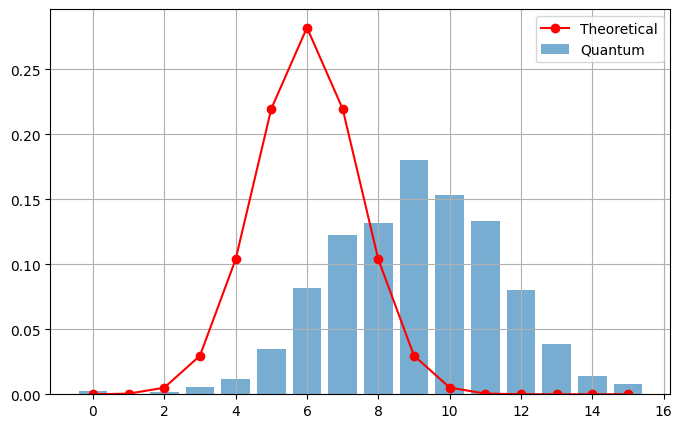

/Users/K/miniforge3/envs/Q/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


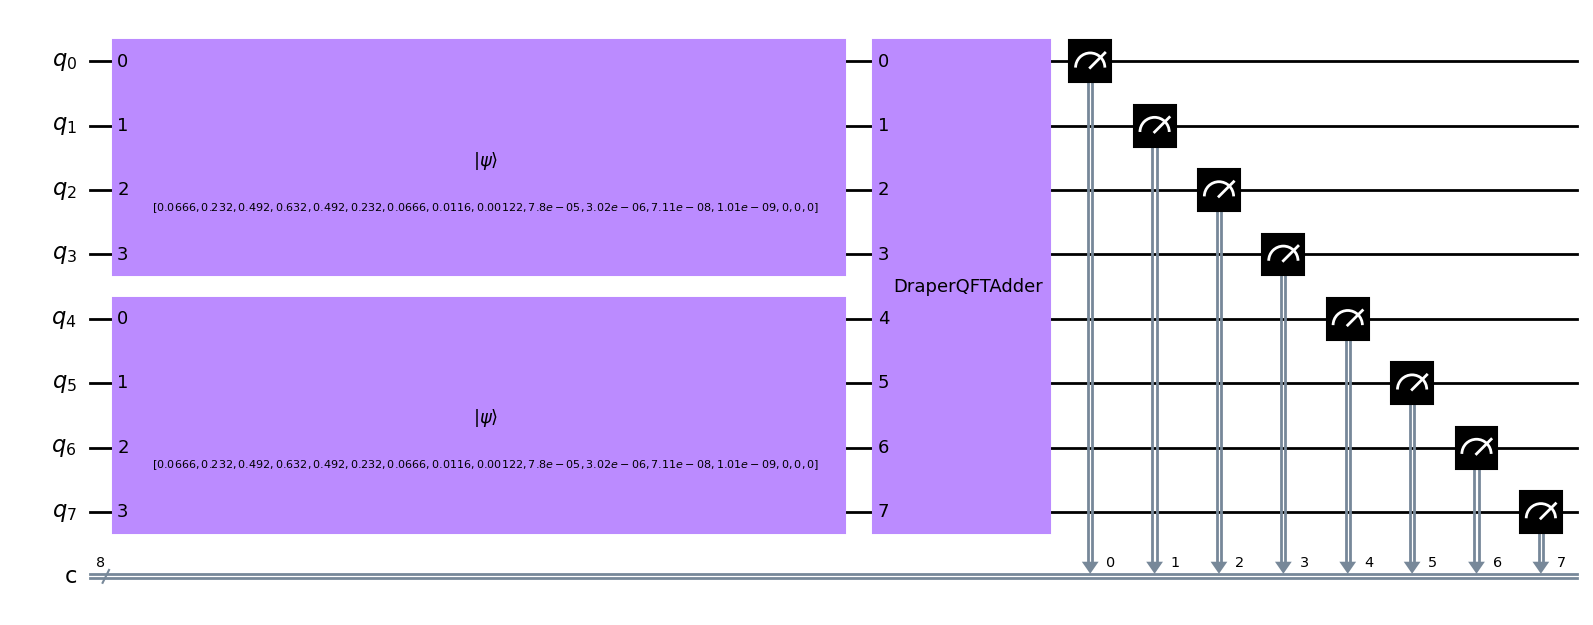

In [3]:
import matplotlib.pyplot as plt
# --- 1. パラメータ設定 ---
n = 4  # 各正規分布を表現するビット数 (0～15 の離散値)
bins = np.arange(2**n)

# 正規分布を離散化して近似 (平均 3, 標準偏差 1, 範囲 0～15)
mu1, sigma1 = 3, 1
mu2, sigma2 = 3, 1

# 離散化した確率質量関数 p_X, p_Y を計算
p_x = np.exp(-0.5 * ((bins - mu1) / sigma1)**2)
p_x = p_x / np.sum(p_x)
p_y = np.exp(-0.5 * ((bins - mu2) / sigma2)**2)
p_y = p_y / np.sum(p_y)

# 振幅 = sqrt(確率) を作成
a_x = np.sqrt(p_x)
a_y = np.sqrt(p_y)

# --- 2. 量子回路の構築 ---
qc = QuantumCircuit(2 * n, 2 * n)  # 2n量子ビット (0..n-1: X, n..2n-1: Y) + 2n 古典ビット

# レジスタ X (qubit 0..n-1) に正規分布状態を初期化
qc.initialize(a_x, list(range(0, n)))
# レジスタ Y (qubit n..2n-1) に正規分布状態を初期化
qc.initialize(a_y, list(range(n, 2 * n)))

# Draper QFT Adder を適用して X ← X + Y (mod 2^n)
adder = DraperQFTAdder(num_state_qubits=n)
qc.append(adder, list(range(2 * n)))  # qubit 0..2n-1 全体に適用

# 測定：qubit i → classical bit i
qc.measure(list(range(2 * n)), list(range(2 * n)))

# --- 3. シミュレーション実行 ---
backend = Aer.get_backend('aer_simulator')
shots = 2000
job = execute(qc, backend=backend, shots=shots)
result = job.result()
counts = result.get_counts()

# --- 4. 測定結果から合成分布を算出 ---
sum_counts = np.zeros(2**n)
for bits, cnt in counts.items():
    # Qiskit のカウント文字列は "c_{2n-1}...c_0" の順なので逆順にして取り扱う
    bitstr = bits[::-1]
    # X の整数値: qubit 0..n-1 → classical bits 0..n-1
    x_int = int(bitstr[0:n][::-1], 2)
    # Y の整数値: qubit n..2n-1 → classical bits n..2n-1
    y_int = int(bitstr[n:2*n][::-1], 2)
    # 加算結果 (mod 2^n)
    s = (x_int + y_int) % (2**n)
    sum_counts[s] += cnt

sum_probs = sum_counts / shots

# --- 5. 理論的な合成分布 (畳み込み) を計算 ---
conv_theory = np.convolve(p_x, p_y)  # 長さ 31
# 0..15 の範囲で取り出し (モジュラ演算の影響はほぼない)
conv_trunc = conv_theory[0:2**n]

# --- 6. 結果のプロット ---
plt.figure(figsize=(8, 5))
# 量子シミュレーション結果
plt.bar(bins, sum_probs, alpha=0.6, label="Quantum")
# 理論的 (畳み込み) 分布
plt.plot(bins, conv_trunc, 'r-o', label="Theoretical")
plt.legend()
plt.grid(True)
plt.show()

qc.draw(output="mpl")

/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/411670122.py:85: UserWarning: Glyph 38626 (\N{CJK UNIFIED IDEOGRAPH-96E2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/411670122.py:85: UserWarning: Glyph 25955 (\N{CJK UNIFIED IDEOGRAPH-6563}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/411670122.py:85: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/411670122.py:85: UserWarning: Glyph 12373 (\N{HIRAGANA LETTER SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/411670122.py:85: UserWarning: Glyph 12428 (\N{HIRAGANA LETTER RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80

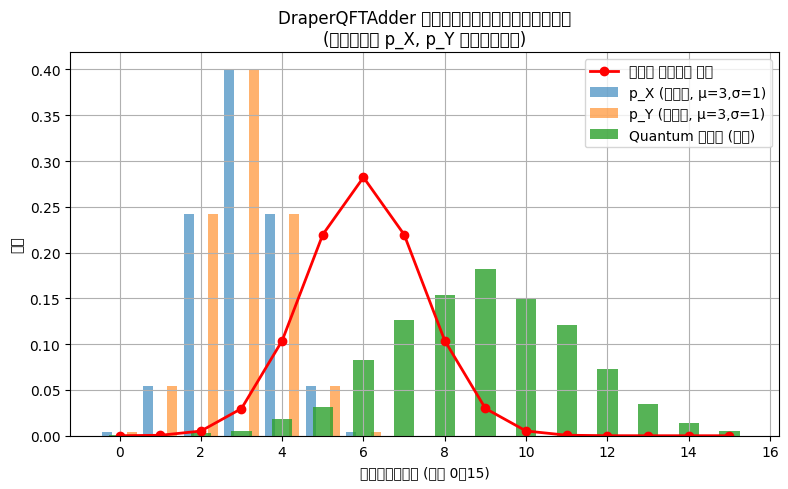

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit.library import DraperQFTAdder

# ─── 1. パラメータ設定 ─────────────────────────────────
n = 4  # 各正規分布を 4 ビット（0～15）の離散値で表現
bins = np.arange(2**n)  # 0,1,2,...,15

# 離散化する正規分布の平均・標準偏差
mu1, sigma1 = 3, 1
mu2, sigma2 = 3, 1

# 0～15 の各ビンにおける正規関数値を計算し、正規化して確率質量関数( PMF )とする
p_x = np.exp(-0.5 * ((bins - mu1) / sigma1) ** 2)
p_x = p_x / np.sum(p_x)

p_y = np.exp(-0.5 * ((bins - mu2) / sigma2) ** 2)
p_y = p_y / np.sum(p_y)

# 振幅エンコーディング用に sqrt を取る
a_x = np.sqrt(p_x)
a_y = np.sqrt(p_y)

# ─── 2. 量子回路の構築 ─────────────────────────────────
# ・2n 量子ビットを用意 (qubit 0..n-1 が X レジスタ、qubit n..2n-1 が Y レジスタ)
# ・測定用に 2n 古典ビットも用意
qc = QuantumCircuit(2 * n, 2 * n)

# レジスタ X (qubit 0..n-1) に正規分布状態を初期化
qc.initialize(a_x, list(range(0, n)))
# レジスタ Y (qubit n..2n-1) に正規分布状態を初期化
qc.initialize(a_y, list(range(n, 2 * n)))

# ─── 3. DraperQFTAdder を適用して X ← (X+Y) mod 2ⁿ ─────────────────
adder = DraperQFTAdder(num_state_qubits=n)
qc.append(adder, list(range(2 * n)))  # qubit 0..(2n-1) に対して適用

# ─── 4. 測定 ─────────────────────────────────
qc.measure(list(range(2 * n)), list(range(2 * n)))

# ─── 5. シミュレーションを実行 ─────────────────────────────────
backend = Aer.get_backend('aer_simulator')
shots = 2000
job = execute(qc, backend=backend, shots=shots)
result = job.result()
counts = result.get_counts()

# ─── 6. 測定結果から合成後の分布を算出 ─────────────────────────────────
sum_counts = np.zeros(2**n)
for bitstr, cnt in counts.items():
    # Qiskit の counts は "c_{2n-1}...c_0" の順なので一旦逆順にしてから扱う
    rev = bitstr[::-1]
    x_bits = rev[0:n]       # qubit 0..(n-1) が X の測定結果
    y_bits = rev[n:2*n]     # qubit n..(2n-1) が Y の測定結果
    x_int = int(x_bits[::-1], 2)
    y_int = int(y_bits[::-1], 2)
    s = (x_int + y_int) % (2**n)
    sum_counts[s] += cnt

sum_probs = sum_counts / shots  # 量子シミュレーションによる合成後分布の近似確率

# ─── 7. 理論的な合成分布 (古典的離散畳み込み) を計算 ───────────────────────────
conv_theory = np.convolve(p_x, p_y)  # 長さ 31
conv_trunc = conv_theory[:2**n]      # 0～15 の範囲のみ

# ─── 8. 加算前分布と合成後分布をすべて重ねてプロット ───────────────────────────
plt.figure(figsize=(8, 5))

# ① 加算前の分布 p_x, p_y をバーで表示
plt.bar(bins - 0.3, p_x, width=0.25, label="p_X (加算前, μ=3,σ=1)", color='C0', alpha=0.6)
plt.bar(bins + 0.3, p_y, width=0.25, label="p_Y (加算前, μ=3,σ=1)", color='C1', alpha=0.6)

# ② 量子シミュレータから得られた合成後分布 (測定結果) をバーで表示（中央寄せ）
plt.bar(bins, sum_probs, width=0.5, label="Quantum 加算後 (測定)", color='C2', alpha=0.8)

# ③ 理論的に畳み込んだ合成分布を線グラフで重ねる
plt.plot(bins, conv_trunc, 'r-o', label="古典的 畳み込み 理論", linewidth=2)

plt.xlabel("離散化された値 (整数 0～15)")
plt.ylabel("確率")
plt.title("DraperQFTAdder を用いた正規分布同士の加算結果\n(加算前分布 p_X, p_Y も重ねて表示)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/1233699641.py:86: UserWarning: Glyph 38626 (\N{CJK UNIFIED IDEOGRAPH-96E2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/1233699641.py:86: UserWarning: Glyph 25955 (\N{CJK UNIFIED IDEOGRAPH-6563}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/1233699641.py:86: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/1233699641.py:86: UserWarning: Glyph 12373 (\N{HIRAGANA LETTER SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/1233699641.py:86: UserWarning: Glyph 12428 (\N{HIRAGANA LETTER RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65v

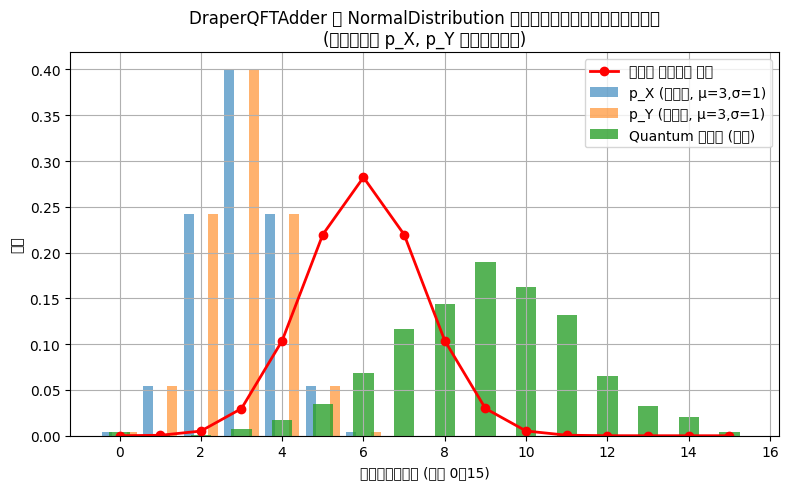

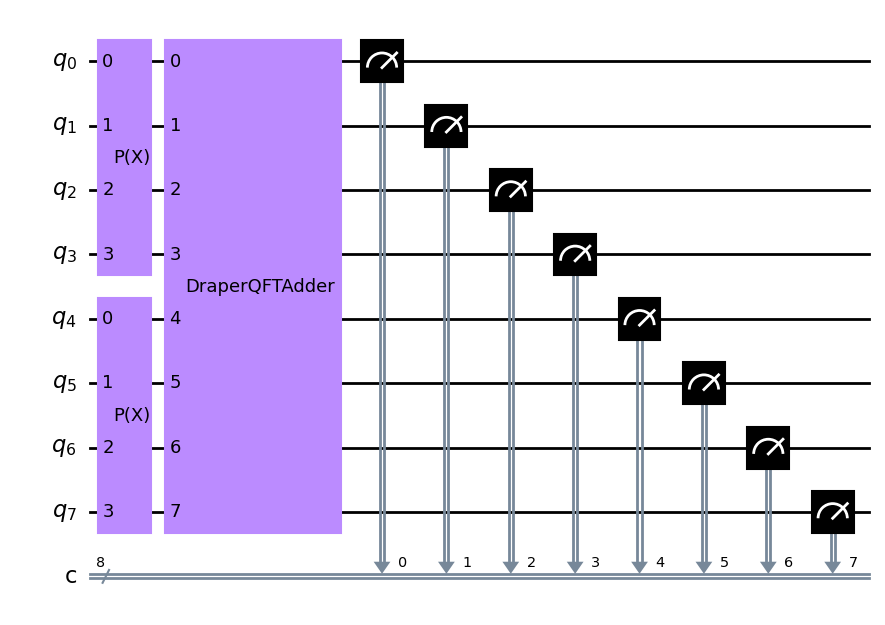

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit.library import DraperQFTAdder
from qiskit_finance.circuit.library import NormalDistribution

# ─── 1. パラメータ設定 ─────────────────────────────────
n = 4  # 各正規分布を 4 ビット（0～15）の離散値で表現
bins = np.arange(2**n)  # 0,1,2,...,15

# 離散化する正規分布の平均・標準偏差
mu1, sigma1 = 3, 1
mu2, sigma2 = 3, 1

# NormalDistribution クラスで離散正規分布を生成
# bounds は [low, high] の範囲で最小・最大値を指定
low, high = 0, 15

normal_dist_x = NormalDistribution(num_qubits=n, mu=mu1, sigma=sigma1, bounds=(low, high))
normal_dist_y = NormalDistribution(num_qubits=n, mu=mu2, sigma=sigma2, bounds=(low, high))

# 正規分布の確率質量関数（理論的な離散 PMF）を取得
p_x = normal_dist_x.probabilities
p_y = normal_dist_y.probabilities

# ─── 2. 量子回路の構築 ─────────────────────────────────
# ・2n 量子ビットを用意 (qubit 0..n-1 が X レジスタ、qubit n..2n-1 が Y レジスタ)
# ・測定用に 2n 古典ビットも用意
qc = QuantumCircuit(2 * n, 2 * n)

# レジスタ X (qubit 0..n-1) に NormalDistribution 回路を追加
qc.append(normal_dist_x, list(range(0, n)))
# レジスタ Y (qubit n..2n-1) に NormalDistribution 回路を追加
qc.append(normal_dist_y, list(range(n, 2 * n)))

# ─── 3. DraperQFTAdder を適用して X ← (X+Y) mod 2ⁿ ─────────────────
adder = DraperQFTAdder(num_state_qubits=n)
qc.append(adder, list(range(2 * n)))  # qubit 0..(2n-1) に対して適用

# ─── 4. 測定 ─────────────────────────────────
qc.measure(list(range(2 * n)), list(range(2 * n)))

# ─── 5. シミュレーションを実行 ─────────────────────────────────
backend = Aer.get_backend('aer_simulator')
shots = 2000
job = execute(qc, backend=backend, shots=shots)
result = job.result()
counts = result.get_counts()

# ─── 6. 測定結果から合成後の分布を算出 ─────────────────────────────────
sum_counts = np.zeros(2**n)
for bitstr, cnt in counts.items():
    # Qiskit の counts は "c_{2n-1}...c_0" の順なので一旦逆順にしてから扱う
    rev = bitstr[::-1]
    x_bits = rev[0:n]       # qubit 0..(n-1) が X の測定結果
    y_bits = rev[n:2*n]     # qubit n..(2n-1) が Y の測定結果
    x_int = int(x_bits[::-1], 2)
    y_int = int(y_bits[::-1], 2)
    s = (x_int + y_int) % (2**n)
    sum_counts[s] += cnt

sum_probs = sum_counts / shots  # 量子シミュレーションによる合成後分布の近似確率

# ─── 7. 理論的な合成分布 (古典的離散畳み込み) を計算 ───────────────────────────
conv_theory = np.convolve(p_x, p_y)  # 長さ 31
conv_trunc = conv_theory[:2**n]      # 0～15 の範囲のみ

# ─── 8. 加算前分布と合成後分布をすべて重ねてプロット ───────────────────────────
plt.figure(figsize=(8, 5))

# ① 加算前の分布 p_x, p_y をバーで表示
plt.bar(bins - 0.3, p_x, width=0.25, label="p_X (加算前, μ=3,σ=1)", color='C0', alpha=0.6)
plt.bar(bins + 0.3, p_y, width=0.25, label="p_Y (加算前, μ=3,σ=1)", color='C1', alpha=0.6)

# ② 量子シミュレータから得られた合成後分布 (測定結果) をバーで表示（中央寄せ）
plt.bar(bins, sum_probs, width=0.5, label="Quantum 加算後 (測定)", color='C2', alpha=0.8)

# ③ 理論的に畳み込んだ合成分布を線グラフで重ねる
plt.plot(bins, conv_trunc, 'r-o', label="古典的 畳み込み 理論", linewidth=2)

plt.xlabel("離散化された値 (整数 0～15)")
plt.ylabel("確率")
plt.title("DraperQFTAdder と NormalDistribution を用いた正規分布同士の加算結果\n(加算前分布 p_X, p_Y も重ねて表示)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

qc.draw(output="mpl")

/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/2230559015.py:82: UserWarning: Glyph 38626 (\N{CJK UNIFIED IDEOGRAPH-96E2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/2230559015.py:82: UserWarning: Glyph 25955 (\N{CJK UNIFIED IDEOGRAPH-6563}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/2230559015.py:82: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/2230559015.py:82: UserWarning: Glyph 12373 (\N{HIRAGANA LETTER SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/2230559015.py:82: UserWarning: Glyph 12428 (\N{HIRAGANA LETTER RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65v

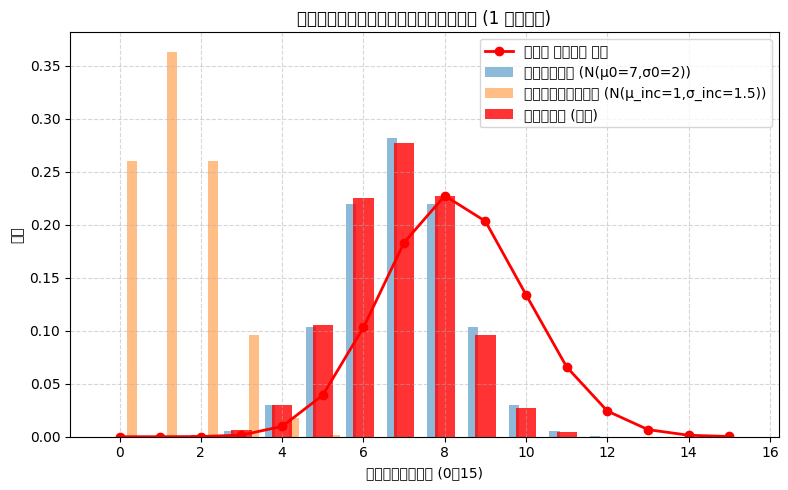

/Users/K/miniforge3/envs/Q/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


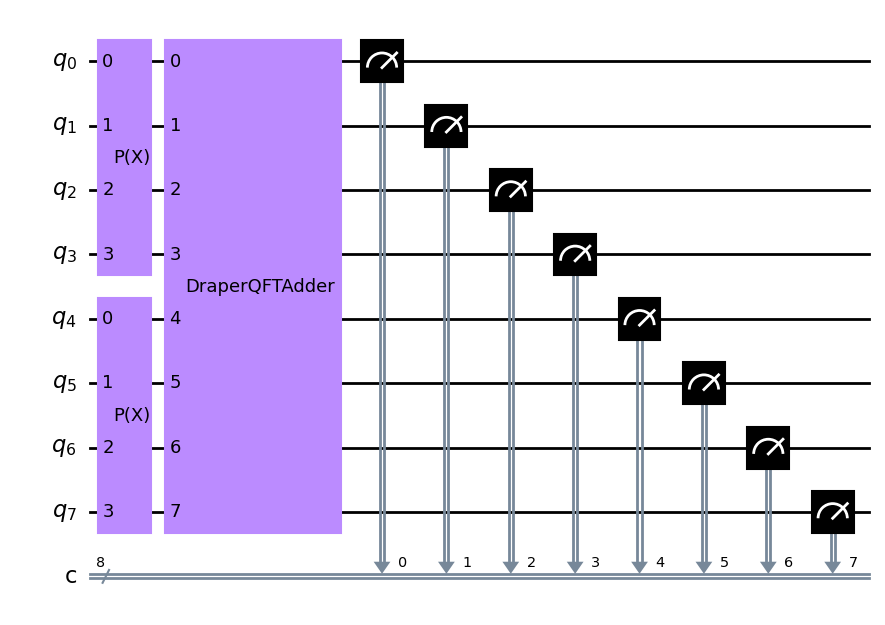

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit.library import DraperQFTAdder
from qiskit_finance.circuit.library import NormalDistribution

# 1. パラメータ設定
n = 4                    # 4 ビット離散化
dim = 2**n               # 16 段階
mu0 = 7.0                # 初期価格分布の平均
sigma0 = 2.0             # 初期価格分布の標準偏差
mu_inc = 1.0             # インクリメント分布の平均
sigma_inc = 1.5          # インクリメント分布の標準偏差
p_min = 0.0              # 価格の最小値
p_max = 15.0             # 価格の最大値

# 2. 量子回路構築
qc = QuantumCircuit(2 * n, 2 * n)

# 初期価格レジスタに N(mu0, sigma0) を離散化して用意
init_dist = NormalDistribution(num_qubits=n,
                               mu=mu0,
                               sigma=sigma0,
                               bounds=(p_min, p_max))
qc.append(init_dist, list(range(0, n)))

# インクリメントレジスタに N(mu_inc, sigma_inc) を離散化して用意
inc_dist = NormalDistribution(num_qubits=n,
                              mu=mu_inc,
                              sigma=sigma_inc,
                              bounds=(p_min, p_max))
qc.append(inc_dist, list(range(n, 2*n)))

# DraperQFTAdder で「初期価格 + インクリメント」を加算
adder = DraperQFTAdder(num_state_qubits=n)
qc.append(adder, list(range(2*n)))

# 測定（ここでは新価格レジスタ部分だけ実質的に使う）
qc.measure(list(range(2*n)), list(range(2*n)))

# 3. シミュレーション実行
backend = Aer.get_backend('aer_simulator')
shots = 5000
job = execute(qc, backend=backend, shots=shots)
result = job.result()
counts = result.get_counts()

# 4. 測定結果の集計 → 新価格分布を取得
new_counts = np.zeros(dim, dtype=int)
for bitstr, cnt in counts.items():
    rev = bitstr[::-1]
    k_new_bits = rev[0:n]
    k_new = int(k_new_bits[::-1], 2)
    new_counts[k_new] += cnt
pmf_new = new_counts / shots

# 5. 理論的な合成分布（古典的離散畳み込み）
p_init = init_dist.probabilities   # 初期分布の理論 PMF (長さ 16)
p_inc = inc_dist.probabilities     # インクリメント分布の理論 PMF (長さ 16)
conv_theory = np.convolve(p_init, p_inc)     # 長さ 31
conv_trunc = conv_theory[:dim]               # 0～15 の範囲にトリミング

# 6. プロット
k_vals = np.arange(dim)
p_vals = p_min + (k_vals / (dim - 1)) * (p_max - p_min)

plt.figure(figsize=(8, 5))
plt.bar(p_vals - 0.3, p_init, width=0.25,
        label="初期価格分布 (N(μ0=7,σ0=2))", color='C0', alpha=0.5)
plt.bar(p_vals + 0.3, p_inc, width=0.25,
        label="インクリメント分布 (N(μ_inc=1,σ_inc=1.5))", color='C1', alpha=0.5)
plt.bar(p_vals, pmf_new, width=0.5,
        label="量子加算後 (測定)", color='red', alpha=0.8)
plt.plot(p_vals, conv_trunc, 'r-o', label="古典的 畳み込み 理論", linewidth=2)

plt.xlabel("離散化された価格 (0～15)")
plt.ylabel("確率")
plt.title("正規分布同士の算術加算による価格分布 (1 ステップ)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

qc.draw(output="mpl")

/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/2017199707.py:128: UserWarning: Glyph 38626 (\N{CJK UNIFIED IDEOGRAPH-96E2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/2017199707.py:128: UserWarning: Glyph 25955 (\N{CJK UNIFIED IDEOGRAPH-6563}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/2017199707.py:128: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/2017199707.py:128: UserWarning: Glyph 12373 (\N{HIRAGANA LETTER SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/2017199707.py:128: UserWarning: Glyph 12428 (\N{HIRAGANA LETTER RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5

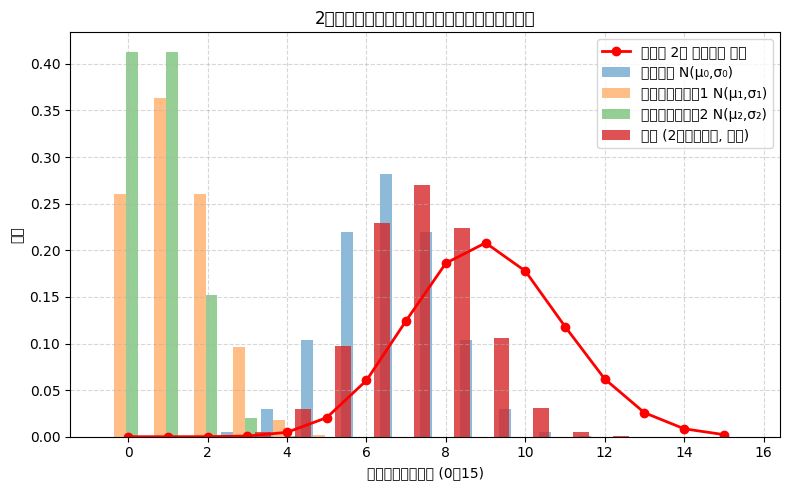

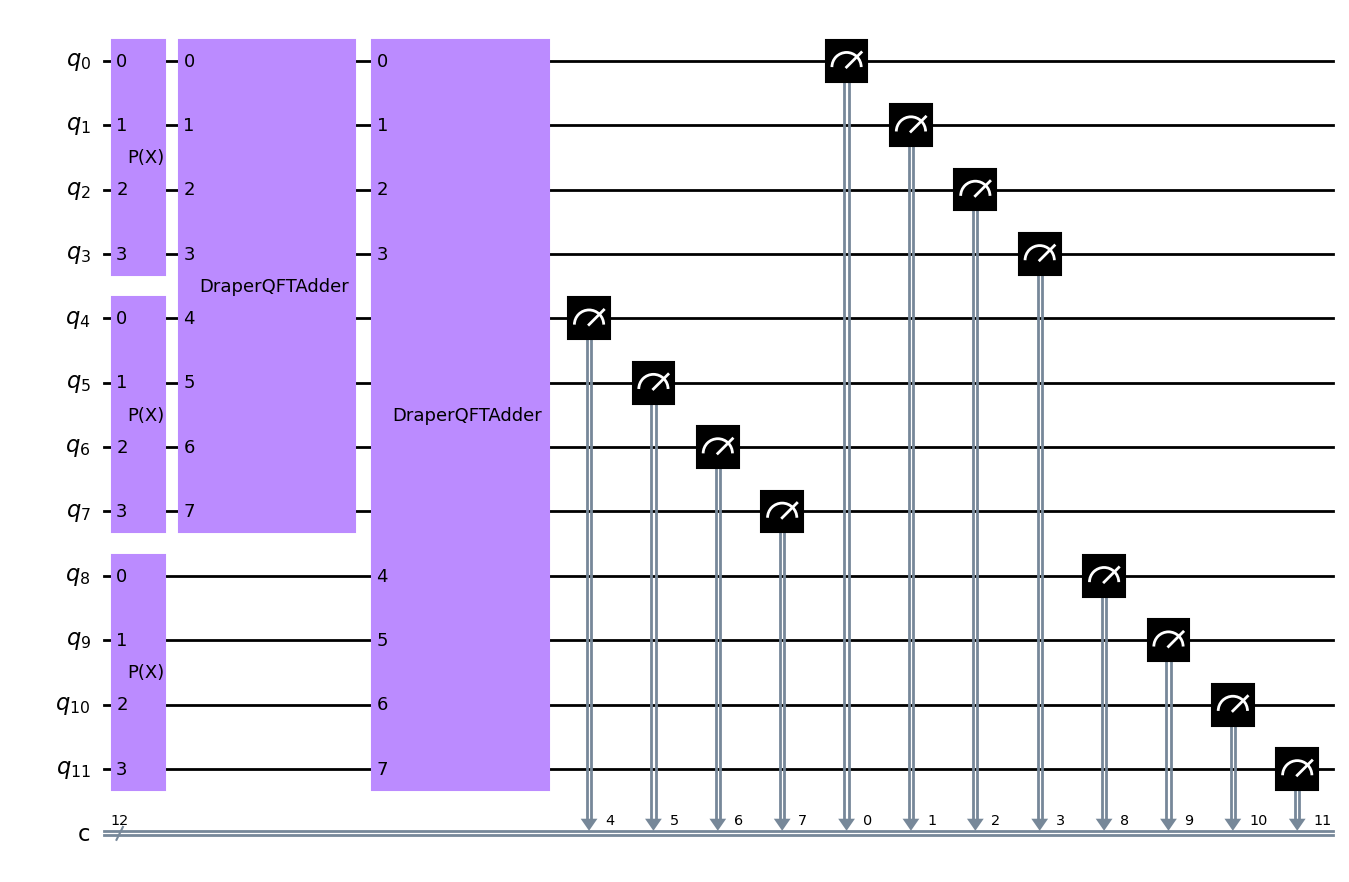

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit.library import DraperQFTAdder
from qiskit_finance.circuit.library import NormalDistribution

# ─── 0. 前提 ─────────────────────────────────────────────
# Qiskit および qiskit-finance がインストールされた環境で実行してください：
#   pip install qiskit qiskit-finance

# ─── 1. パラメータ設定 ────────────────────────────────────────
n = 4                    # 各レジスタを 4 ビットで離散化
dim = 2**n               # 16 段階

# (a) 初期価格分布の平均・標準偏差
mu0    = 7.0             # 初期価格の正規分布平均
sigma0 = 2.0             # 初期価格の正規分布標準偏差

# (b) ステップ1 のインクリメント分布（1時間ステップ分）の平均・標準偏差
mu_inc1    = 1.0         # ステップ1 インクリメント平均
sigma_inc1 = 1.5         # ステップ1 インクリメント標準偏差

# (c) ステップ2 のインクリメント分布（さらに次の 1時間ステップ）の平均・標準偏差
mu_inc2    = 0.5         # ステップ2 インクリメント平均
sigma_inc2 = 1.0         # ステップ2 インクリメント標準偏差

# (d) 価格の連続値範囲：離散化ビット列 0 → p_min, 2^n-1 → p_max
p_min = 0.0              # 価格の最小（0）
p_max = 15.0             # 価格の最大（15）

#  レジスタ対応：
#   qubits  0..(n-1)    : 初期価格 P₀
#   qubits  n..(2n-1)   : インクリメント ΔP₁
#   qubits  2n..(3n-1)  : インクリメント ΔP₂

# ─── 2. 量子回路の構築 ───────────────────────────────────────
qc = QuantumCircuit(3 * n, 3 * n)

# (1) レジスタ 0..(n-1) に「初期価格分布 N(mu0, sigma0)」を生成
init_dist = NormalDistribution(num_qubits=n,
                               mu=mu0,
                               sigma=sigma0,
                               bounds=(p_min, p_max))
qc.append(init_dist, list(range(0, n)))

# (2) レジスタ n..(2n-1) に「ステップ1 インクリメント分布 N(mu_inc1, sigma_inc1)」
inc1_dist = NormalDistribution(num_qubits=n,
                               mu=mu_inc1,
                               sigma=sigma_inc1,
                               bounds=(p_min, p_max))
qc.append(inc1_dist, list(range(n, 2*n)))

# (3) レジスタ 2n..(3n-1) に「ステップ2 インクリメント分布 N(mu_inc2, sigma_inc2)」
inc2_dist = NormalDistribution(num_qubits=n,
                               mu=mu_inc2,
                               sigma=sigma_inc2,
                               bounds=(p_min, p_max))
qc.append(inc2_dist, list(range(2*n, 3*n)))

# (4) Adder1: P₀ (qubits 0..n-1) に ΔP₁ (qubits n..2n-1) を足す
adder1 = DraperQFTAdder(num_state_qubits=n)
#  必要なのはちょうど 2n ビット：state_qubits に [0..n-1], addend_qubits に [n..2n-1]
qc.append(adder1, list(range(0, 2*n)))  # = [0,1,2,3, 4,5,6,7]

# (5) Adder2: (P₀+ΔP₁) が入っているレジスタ 0..(n-1) に ΔP₂ (qubits 2n..3n-1) を足す
adder2 = DraperQFTAdder(num_state_qubits=n)
#  ここでも Adder2 は 2n ビット引数を期待するので、
#  "state_qubits"= [0..(n-1)]、"addend_qubits"= [2n..3n-1] をまとめて渡す
qc.append(adder2, list(range(0, n)) + list(range(2*n, 3*n)))
#  例えば n=4 のときは [0,1,2,3, 8,9,10,11] の長さ 8 のリストを渡す

# (6) 測定：新価格レジスタ（qubits 0..n-1）が最終的な「2ステップ後の価格」を持つので、
#     いずれにせよ全 3n ビットを測定して働き方を簡単にしています。
qc.measure(list(range(3*n)), list(range(3*n)))

# ─── 3. シミュレーションを実行 ───────────────────────────────────
backend = Aer.get_backend('aer_simulator')
shots = 5000
job = execute(qc, backend=backend, shots=shots)
result = job.result()
counts = result.get_counts()

# ─── 4. 測定結果の集計 → 「2ステップ後の価格 (qubits 0..n-1)」を取り出す ─────
new2_counts = np.zeros(dim, dtype=int)
for bitstr, cnt in counts.items():
    # bitstr は "c_{3n-1}...c_0" の文字列なので、逆順にして扱う
    rev = bitstr[::-1]
    # 下位 n ビット rev[0:n] が、最終的な価格 qubits 0..(n-1) の測定結果
    k_final_bits = rev[0:n]
    k_final = int(k_final_bits[::-1], 2)
    new2_counts[k_final] += cnt

pmf_final = new2_counts / shots  # 2ステップ後の離散化整数 k の分布（PMF）

# ─── 5. 理論的な分布（古典的に2回畳み込む） ───────────────────────
p_init = init_dist.probabilities
p_inc1 = inc1_dist.probabilities
p_inc2 = inc2_dist.probabilities

#  古典的離散畳み込みを 2 回行う
conv1 = np.convolve(p_init, p_inc1)   # 長さ 31
conv2 = np.convolve(conv1, p_inc2)    # 長さ 46
conv_trunc2 = conv2[:dim]             # 0..15 の範囲にトリミング

# ─── 6. 結果をプロット ─────────────────────────────────────────
k_vals = np.arange(dim)
p_vals = p_min + (k_vals / (dim - 1)) * (p_max - p_min)

plt.figure(figsize=(8, 5))

# ① 初期分布、インクリメント1、インクリメント2 を薄く並べる
plt.bar(p_vals - 0.5, p_init,   width=0.3, label="初期価格 N(μ₀,σ₀)",    color='C0', alpha=0.5)
plt.bar(p_vals - 0.2, p_inc1,   width=0.3, label="インクリメント1 N(μ₁,σ₁)", color='C1', alpha=0.5)
plt.bar(p_vals + 0.1, p_inc2,   width=0.3, label="インクリメント2 N(μ₂,σ₂)", color='C2', alpha=0.5)

# ② 量子シミュレータによる 2 ステップ後の分布
plt.bar(p_vals + 0.4, pmf_final, width=0.4, label="量子 (2ステップ後, 測定)", color='C3', alpha=0.8)

# ③ 古典的に 2 回畳み込んだ理論分布
plt.plot(p_vals, conv_trunc2, 'r-o', label="古典的 2回 畳み込み 理論", linewidth=2)

plt.xlabel("離散化された価格 (0～15)")
plt.ylabel("確率")
plt.title("2ステップ分の正規分布算術加算による価格分布")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

qc.draw(output="mpl")

/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/1956124796.py:103: UserWarning: Glyph 38626 (\N{CJK UNIFIED IDEOGRAPH-96E2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/1956124796.py:103: UserWarning: Glyph 25955 (\N{CJK UNIFIED IDEOGRAPH-6563}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/1956124796.py:103: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/1956124796.py:103: UserWarning: Glyph 12373 (\N{HIRAGANA LETTER SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/1956124796.py:103: UserWarning: Glyph 12428 (\N{HIRAGANA LETTER RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5

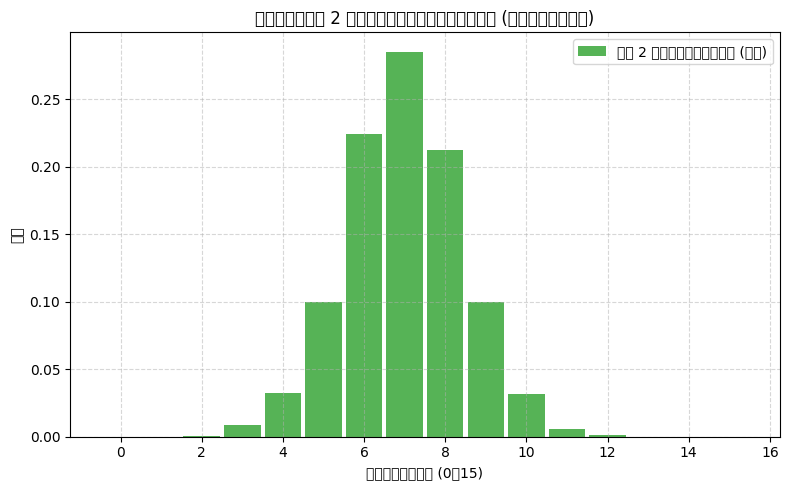

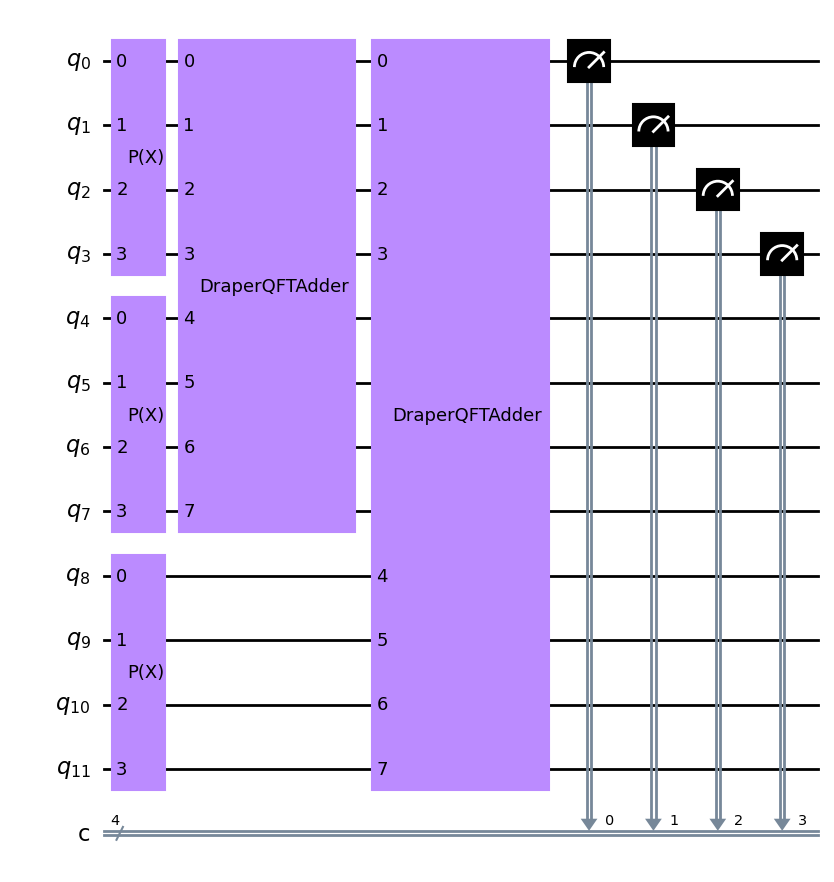

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit.library import DraperQFTAdder
from qiskit_finance.circuit.library import NormalDistribution

# ─── パラメータ設定 ─────────────────────────────────────────
n = 4                    # 各レジスタを 4 ビットで離散化
dim = 2**n               # 16 段階の離散化

# 初期価格分布の平均・標準偏差
mu0 = 7.0                # 初期価格の平均
sigma0 = 2.0             # 初期価格の標準偏差

# 1時間ステップ分のインクリメント分布 (2 ステップ分)
mu_inc1 = 1.0            # ステップ1 のインクリメント平均
sigma_inc1 = 1.5         # ステップ1 のインクリメント標準偏差
mu_inc2 = 0.5            # ステップ2 のインクリメント平均
sigma_inc2 = 1.0         # ステップ2 のインクリメント標準偏差

# 価格の連続値範囲：離散化ビット列 0 → p_min,  2^n-1 → p_max
p_min = 0.0              # 最小価格
p_max = 15.0             # 最大価格

# ─── 量子回路の構築 ─────────────────────────────────────────
# 合計 3n ビットの量子レジスタ（0..n-1: P0（初期価格）,
#                             n..2n-1: ΔP1（ステップ1インクリメント）, 
#                             2n..3n-1: ΔP2（ステップ2インクリメント））
# と古典ビット n 本（最終P の測定用）を用意
qc = QuantumCircuit(3 * n, n)

# (1) 初期価格レジスタ (0..n-1) に N(mu0, sigma0) を離散化した分布を準備
init_dist = NormalDistribution(num_qubits=n,
                               mu=mu0,
                               sigma=sigma0,
                               bounds=(p_min, p_max))
qc.append(init_dist, list(range(0, n)))

# (2) ステップ1 インクリメントレジスタ (n..2n-1) に N(mu_inc1, sigma_inc1) を準備
inc1_dist = NormalDistribution(num_qubits=n,
                               mu=mu_inc1,
                               sigma=sigma_inc1,
                               bounds=(p_min, p_max))
qc.append(inc1_dist, list(range(n, 2*n)))

# (3) DraperQFTAdder を使って、「P0 ← P0 + ΔP1」
adder1 = DraperQFTAdder(num_state_qubits=n)
# adder1 が扱うのは「制御レジスタ: 0..n-1」「加算レジスタ: n..2n-1」
# 実際には DraperQFTAdder に渡す qubit list は長さ 2n
qc.append(adder1, list(range(2*n)))  # qubit 0..(2n-1) に適用

# (4) ステップ2 インクリメントレジスタ (2n..3n-1) に N(mu_inc2, sigma_inc2) を準備
inc2_dist = NormalDistribution(num_qubits=n,
                               mu=mu_inc2,
                               sigma=sigma_inc2,
                               bounds=(p_min, p_max))
qc.append(inc2_dist, list(range(2*n, 3*n)))

# (5) DraperQFTAdder を使って、「P1 ← P1 + ΔP2」
# このとき制御レジスタは「現在の価格レジスタ: 0..n-1」、加算レジスタは「ΔP2: 2n..3n-1」
adder2 = DraperQFTAdder(num_state_qubits=n)
# Qubit ordering for adder2: we need to supply 2n qubits in the order [控制:0..n-1, 加算:2n..3n-1]
control_qubits = list(range(0, n))
addend_qubits = list(range(2*n, 3*n))
qc.append(adder2, control_qubits + addend_qubits)

# (6) 測定：最終的な価格レジスタ (0..n-1) のみを n 本の古典ビットに測定
qc.measure(list(range(0, n)), list(range(0, n)))

# ─── シミュレーション実行 ────────────────────────────────────────
backend = Aer.get_backend('aer_simulator')
shots = 5000
job = execute(qc, backend=backend, shots=shots)
result = job.result()
counts = result.get_counts()

# ─── 測定結果の集計 → 新価格レジスタ (2ステップ分加算済み) の離散整数 k_final の頻度をカウント
final_counts = np.zeros(dim, dtype=int)
for bitstr, cnt in counts.items():
    # Qiskit の counts は "c_{n-1}...c_0" の順で文字列になるので、逆順にしてから扱う
    rev = bitstr[::-1]
    k_final_bits = rev[0:n]
    k_final = int(k_final_bits[::-1], 2)
    final_counts[k_final] += cnt

# k_final の離散分布 (PMF)
pmf_final = final_counts / shots

# ─── 結果プロット ────────────────────────────────────────────────
k_vals = np.arange(dim)
p_vals = p_min + (k_vals / (dim - 1)) * (p_max - p_min)

plt.figure(figsize=(8, 5))
plt.bar(p_vals, pmf_final, width=(p_vals[1] - p_vals[0]) * 0.9,
        label="量子 2 ステップ後の価格分布 (測定)", color='C2', alpha=0.8)

plt.xlabel("離散化された価格 (0～15)")
plt.ylabel("確率")
plt.title("正規分布同士の 2 ステップ算術加算による価格分布 (最終分布のみ測定)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

qc.draw(output="mpl")

/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/691934537.py:176: UserWarning: Glyph 38626 (\N{CJK UNIFIED IDEOGRAPH-96E2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/691934537.py:176: UserWarning: Glyph 25955 (\N{CJK UNIFIED IDEOGRAPH-6563}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/691934537.py:176: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/691934537.py:176: UserWarning: Glyph 12373 (\N{HIRAGANA LETTER SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/691934537.py:176: UserWarning: Glyph 12428 (\N{HIRAGANA LETTER RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65v

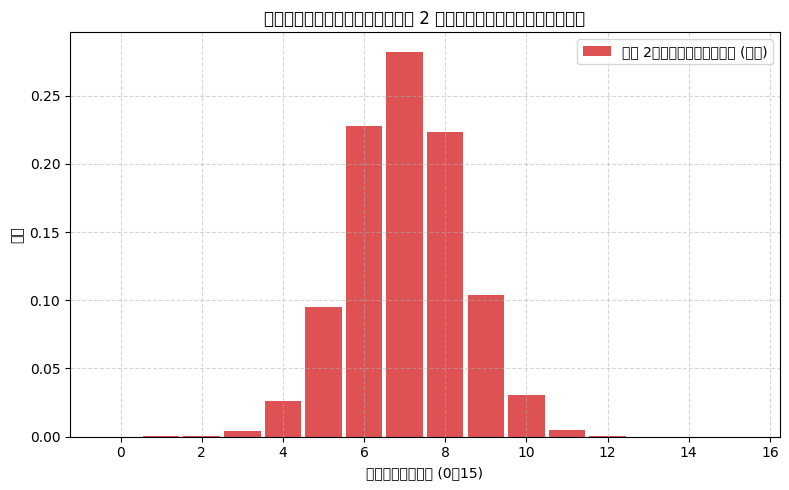

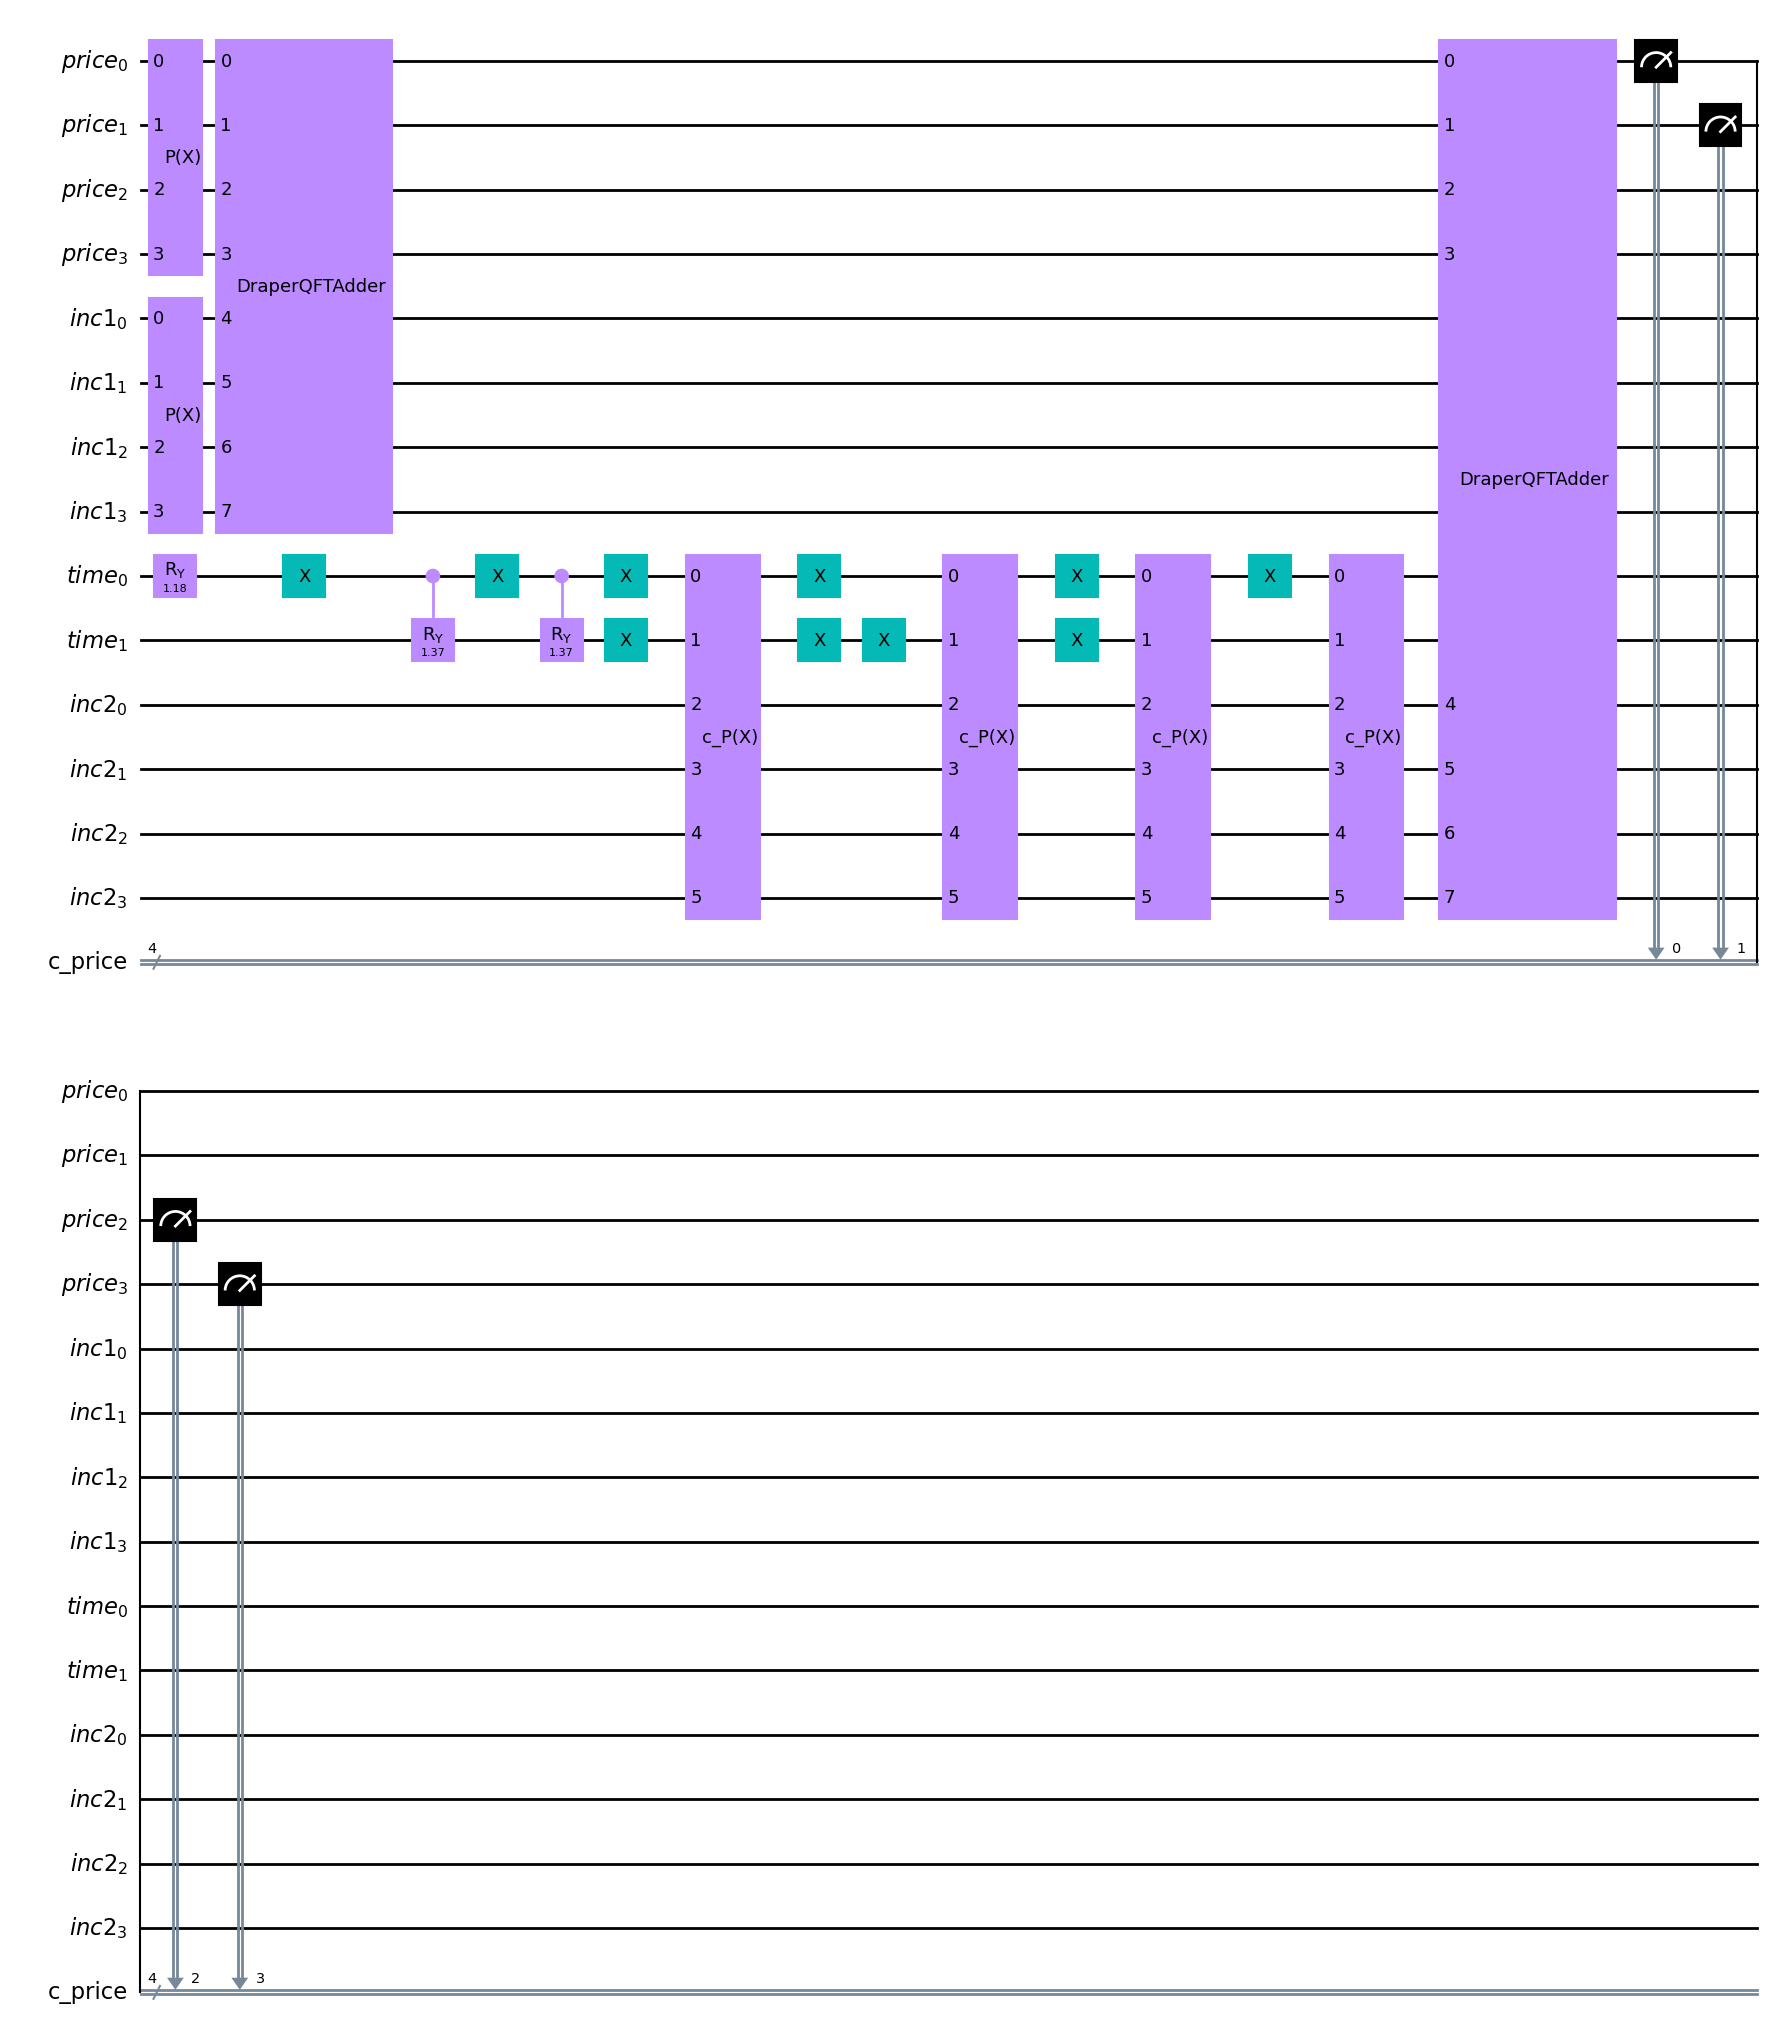

In [24]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.circuit.library import DraperQFTAdder
from qiskit_finance.circuit.library import NormalDistribution

# ─── 0. 前提 ─────────────────────────────────────────────
# Qiskit および qiskit-finance がインストールされた環境で実行してください:
#   pip install qiskit qiskit-finance matplotlib numpy

# ─── 1. パラメータ設定 ────────────────────────────────────────
# 1.1 価格レジスタ・インクリメントレジスタのビット数と価格のレンジ
n = 4                    # 各レジスタを 4 ビットで離散化 (価格/増分は 16 段階)
dim = 2**n               # 16 段階
p_min = 0.0              # 価格（増分）の最小値
p_max = 15.0             # 価格（増分）の最大値

# 1.2 初期価格分布 (ステップ0)
mu0    = 7.0             # 初期価格の正規分布平均
sigma0 = 2.0             # 初期価格の正規分布標準偏差

# 1.3 ステップ1 のインクリメント分布 (1時間固定ステップ)
mu_inc1    = 1.0         # ステップ1 インクリメントの平均
sigma_inc1 = 1.5         # ステップ1 インクリメントの標準偏差

# 1.4 ステップ2 のインクリメント分布の「ベースパラメータ」
mu_inc2     = 0.5        # ステップ2 インクリメントの平均（固定）
sigma_base2 = 1.0        # ステップ2 のベース標準偏差 (\sigma_base) → 実際の σ = σ_base * sqrt(ΔT)

# 1.5 ホールディングタイム (ΔT) 分布を指数分布 Exp(1) として 4 段階に離散化
#      ここでは m = 2 ビットで {00,01,10,11} の 4 状態を表現し、
#      それぞれの対応時間を τ_j = {0.2, 0.6, 1.0, 1.4} とする例。
m = 2  # 時間レジスタのビット数
tau_vals = np.array([0.2, 0.6, 1.0, 1.4])  # j=0..3 に対応する ΔT の値

# 指数分布 Exp(λ=1) の PDF ∝ exp(-t) なので、
# 各 τ_j の「確率質量」π_j を（点近似として） exp(-τ_j) を正規化して求める
raw = np.exp(-tau_vals)
pi_tau = raw / raw.sum()  # 4 要素の確率質量

# ─── 2. 量子レジスタと古典レジスタの準備 ─────────────────────────
# - qr_price:   価格レジスタ (n ビット)
# - qr_inc1:    ステップ1 インクリメントレジスタ (n ビット)
# - qr_time:    ホールディングタイムレジスタ (m ビット)
# - qr_inc2:    ステップ2 インクリメントレジスタ (n ビット)
#
# 古典レジスタ:
# - cr_price: 価格レジスタ測定用 (n ビット)
qc = QuantumCircuit(
    QuantumRegister(n, name="price"),
    QuantumRegister(n, name="inc1"),
    QuantumRegister(m, name="time"),
    QuantumRegister(n, name="inc2"),
    ClassicalRegister(n, name="c_price")
)

qr_price = qc.qubits[0:n]                     # 0..(n-1): 価格レジスタ
qr_inc1  = qc.qubits[n:2*n]                   # n..(2n-1): ステップ1 インクリメント
qr_time  = qc.qubits[2*n:2*n+m]               # 2n..(2n+m-1): 時間レジスタ (m=2)
qr_inc2  = qc.qubits[2*n+m:3*n+m]             # (2n+m)..(3n+m-1): ステップ2 インクリメント

cr_price = qc.clbits                        # 古典ビットは仮に「c_price」(n 本) のみ利用

# （※古典レジスタは価格レジスタだけを測定するため n 本用意しています）
# ─── 3. 量子回路構築 ─────────────────────────────────────────────

# 3.1 (ステップ0) 初期価格分布を qr_price に用意
#      NormalDistribution(num_qubits=n, mu0,sigma0,bounds=(p_min,p_max))
init_dist = NormalDistribution(
    num_qubits=n,
    mu=mu0,
    sigma=sigma0,
    bounds=(p_min, p_max)
)
qc.append(init_dist, qr_price)  # qr_price[0..n-1] に適用

# 3.2 (ステップ1) インクリメント1 を qr_inc1 に用意
inc1_dist = NormalDistribution(
    num_qubits=n,
    mu=mu_inc1,
    sigma=sigma_inc1,
    bounds=(p_min, p_max)
)
qc.append(inc1_dist, qr_inc1)   # qr_inc1[n..2n-1] に適用

# 3.3 (ステップ1) DraperQFTAdder で「価格 ← 価格 + インクリメント1」
adder1 = DraperQFTAdder(num_state_qubits=n)
#   引数は [状態レジスタ: qr_price, 加算レジスタ: qr_inc1] の合計 2n ビット
qc.append(adder1, qr_price + qr_inc1)

# 3.4 ホールディングタイム分布を qr_time に準備 (m=2 ビット)
#   ── 2 ビットの重ね合わせを作るため、まず qr_time[0] を回転
theta1 = 2 * np.arccos(np.sqrt(pi_tau[0] + pi_tau[1]))
qc.ry(theta1, qr_time[0])
#   ── 次に qr_time[1] を qr_time[0] の状態制御付きで回転
phi0 = 2 * np.arccos(np.sqrt(pi_tau[0] / (pi_tau[0] + pi_tau[1]))) if (pi_tau[0] + pi_tau[1]) > 0 else 0.0
phi1 = 2 * np.arccos(np.sqrt(pi_tau[2] / (pi_tau[2] + pi_tau[3]))) if (pi_tau[2] + pi_tau[3]) > 0 else 0.0

#   ── qr_time[0] = |0> の場合 → X → Controlled-Ry(phi0) → X
qc.x(qr_time[0])
qc.cry(phi0, qr_time[0], qr_time[1])
qc.x(qr_time[0])
#   ── qr_time[0] = |1> の場合 → Controlled-Ry(phi1)
qc.cry(phi1, qr_time[0], qr_time[1])
# これで qr_time は √π₀|00> + √π₁|01> + √π₂|10> + √π₃|11> の重ね合わせ

# 3.5 (ステップ2) ホールディングタイムに応じてインクリメント2を qr_inc2 に準備
#      各 j = 0..3 について σ_j = σ_base2 * sqrt(τ_j)
norm_circs = []
for j in range(4):
    sigma_j = sigma_base2 * np.sqrt(tau_vals[j])
    dist_j = NormalDistribution(
        num_qubits=n,
        mu=mu_inc2,
        sigma=sigma_j,
        bounds=(p_min, p_max)
    )
    norm_circs.append(dist_j)

# 4 段階のいずれか (qr_time = |j>) のときだけ qr_inc2 に dist_j を適用
# 「qr_time のビットが bstr[j]＝2進数 j(逆順) であれば dist_j.control(2) を適用」
for j in range(4):
    # 2 ビットのビット文字列 (逆順) を得る例: j=0 -> "00", j=1 -> "10"(逆順では"01")
    bstr = format(j, f'0{m}b')[::-1]
    # bstr[idx]=='0' のときは X をかませることで「|0>→|1>」状態にし、
    # 「多重制御 (2 control) → dist_j」をかける → その後 X を戻す
    for idx in range(m):
        if bstr[idx] == '0':
            qc.x(qr_time[idx])
    # ここで qr_time が |11> になっている状態で dist_j を qr_inc2 に適用
    qc.append(norm_circs[j].control(2), qr_time + qr_inc2)
    # X を元に戻す
    for idx in range(m):
        if bstr[idx] == '0':
            qc.x(qr_time[idx])

# 3.6 (ステップ2) DraperQFTAdder で「価格 ← 価格 + インクリメント2」
adder2 = DraperQFTAdder(num_state_qubits=n)
qc.append(adder2, qr_price + qr_inc2)

# 3.7 最終的に「価格レジスタだけ」を測定 (qubits 0..n-1 → classical bits 0..n-1)
qc.measure(qr_price, cr_price)

# ─── 4. シミュレーション実行 ────────────────────────────────────────
backend = Aer.get_backend('aer_simulator')
shots = 5000
job = execute(qc, backend=backend, shots=shots)
result = job.result()
counts = result.get_counts()

# ─── 5. 測定結果の集計 → 2ステップ後の「価格レジスタ (4 ビット)」の PMF を計算 ─────
final_counts = np.zeros(dim, dtype=int)
for bitstr, cnt in counts.items():
    # bitstr は "c_{3n+m-1}...c_0" の順 (今回は古典ビット数 = n なので、文字列長 = n)
    # → 逆順にして下位 n ビットを読む操作だけで OK
    rev = bitstr[::-1]
    k_final = int(rev[0:n][::-1], 2)  # 0..(n-1) を整数に変換
    final_counts[k_final] += cnt

pmf_final = final_counts / shots  # 2ステップ後の価格分布 (離散整数 0..15 の PMF)

# ─── 6. 結果をプロット ─────────────────────────────────────────────
k_vals = np.arange(dim)
p_vals = p_min + (k_vals / (dim - 1)) * (p_max - p_min)  # 離散整数→実数価格

plt.figure(figsize=(8, 5))
plt.bar(p_vals, pmf_final, width=(p_vals[1] - p_vals[0]) * 0.9,
        label="量子 2ステップ後の価格分布 (測定)", color='C3', alpha=0.8)
plt.xlabel("離散化された価格 (0～15)")
plt.ylabel("確率")
plt.title("ホールディングタイムを考慮した 2 ステップ算術加算による価格分布")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# （オプション）構築した量子回路を描画して確認する場合
qc.draw(output="mpl")


/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/2014199602.py:171: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/2014199602.py:171: UserWarning: Glyph 32066 (\N{CJK UNIFIED IDEOGRAPH-7D42}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/2014199602.py:171: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/2014199602.py:171: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/2014199602.py:171: UserWarning: Glyph 20385 (\N{CJK UNIFIED IDEOGRAPH-4FA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng4

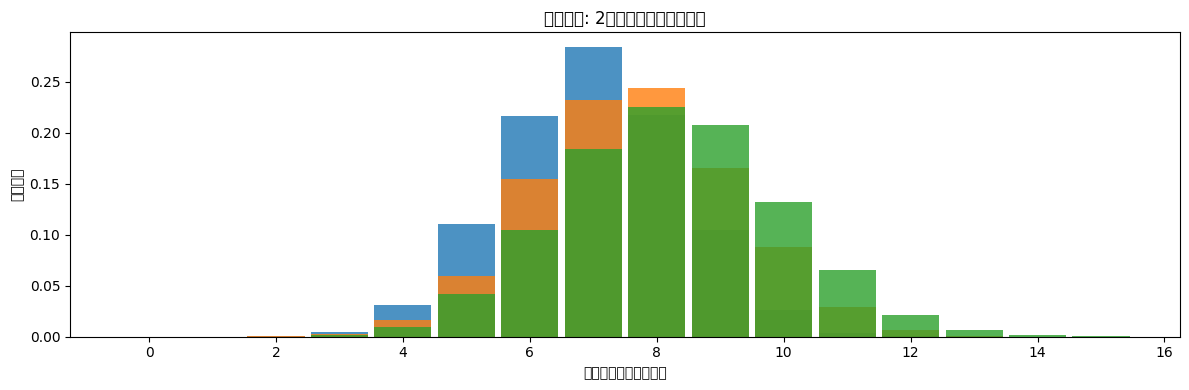

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.circuit.library import DraperQFTAdder
from qiskit_finance.circuit.library import NormalDistribution

# ─── 1. パラメータ設定 ─────────────────────────────────────────
n = 4                    # 価格・インクリメントを 4ビットで離散化 (16 段階)
dim = 2**n               # 16 段階
p_min = 0.0              # 価格（増分）の最小値
p_max = 15.0             # 価格（増分）の最大値

# 初期価格分布 (ステップ0)
mu0    = 7.0             # 初期価格の平均
sigma0 = 2.0             # 初期価格の標準偏差

# ステップ1 のインクリメント分布
mu_inc1    = 1.0         # 平均
sigma_inc1 = 1.5         # 標準偏差

# ステップ2 のインクリメント分布ベースパラメータ
mu_inc2     = 0.5        # 平均
sigma_base2 = 1.0        # ベース標準偏差 (実際は σ = σ_base2 * sqrt(ΔT))

# ホールディングタイム (ΔT) 分布を指数分布 Exp(1) として 4 段階に離散化
m = 2  # 2 ビット → 4 段階
tau_vals = np.array([0.2, 0.6, 1.0, 1.4])  # j=0..3 に対応する ΔT の値
raw = np.exp(-tau_vals)                    # Exp(1) の PDF ∝ exp(-t)
pi_tau = raw / raw.sum()                   # 4 段階の確率質量

# ─── 2. 量子レジスタと古典レジスタの準備 ─────────────────────────
qr_price = QuantumRegister(n, name="price")    # 0..3: 価格レジスタ
qr_inc1  = QuantumRegister(n, name="inc1")     # 4..7: ステップ1 インクリメント
qr_time  = QuantumRegister(m, name="time")     # 8..9: 時間レジスタ (m=2)
qr_inc2  = QuantumRegister(n, name="inc2")     # 10..13: ステップ2 インクリメント

cr_inc1  = ClassicalRegister(n, name="c_inc1") # 4 ビット測定用
cr_inc2  = ClassicalRegister(n, name="c_inc2") # 4 ビット測定用
cr_price = ClassicalRegister(n, name="c_price")# 4 ビット測定用

qc = QuantumCircuit(
    qr_price, qr_inc1, qr_time, qr_inc2,
    cr_inc1, cr_inc2, cr_price
)

# ─── 3. 回路構築 ───────────────────────────────────────────────

# 3.1 初期価格分布を qr_price に生成
init_dist = NormalDistribution(
    num_qubits=n,
    mu=mu0,
    sigma=sigma0,
    bounds=(p_min, p_max)
)
qc.append(init_dist, qr_price)

# 3.2 ステップ1 のインクリメントを qr_inc1 に生成
inc1_dist = NormalDistribution(
    num_qubits=n,
    mu=mu_inc1,
    sigma=sigma_inc1,
    bounds=(p_min, p_max)
)
qc.append(inc1_dist, qr_inc1)

# 3.3 DraperQFTAdder で「価格 ← 価格 + インクリメント1」
adder1 = DraperQFTAdder(num_state_qubits=n)
qc.append(adder1, qr_price[:] + qr_inc1[:])

# 3.4 ホールディングタイム分布を qr_time に準備 (2ビットで 4 段階)
theta1 = 2 * np.arccos(np.sqrt(pi_tau[0] + pi_tau[1]))
qc.ry(theta1, qr_time[0])
phi0 = 2 * np.arccos(np.sqrt(pi_tau[0] / (pi_tau[0] + pi_tau[1]))) if (pi_tau[0] + pi_tau[1]) > 0 else 0.0
phi1 = 2 * np.arccos(np.sqrt(pi_tau[2] / (pi_tau[2] + pi_tau[3]))) if (pi_tau[2] + pi_tau[3]) > 0 else 0.0

# qr_time[0] = |0> のとき qr_time[1] を φ0 回転
qc.x(qr_time[0])
qc.cry(phi0, qr_time[0], qr_time[1])
qc.x(qr_time[0])
# qr_time[0] = |1> のとき qr_time[1] を φ1 回転
qc.cry(phi1, qr_time[0], qr_time[1])

# 3.5 ステップ2 のインクリメントを qr_inc2 に準備 (ホールディングタイム制御付き)
norm_circs = []
for j in range(4):
    sigma_j = sigma_base2 * np.sqrt(tau_vals[j])
    dist_j = NormalDistribution(
        num_qubits=n,
        mu=mu_inc2,
        sigma=sigma_j,
        bounds=(p_min, p_max)
    )
    norm_circs.append(dist_j)

# 各 j について「qr_time=|j> のときに dist_j を qr_inc2 に適用」
for j in range(4):
    bstr = format(j, f'0{m}b')[::-1]  # 逆順のビット文字列
    # ビットが '0' の場合は X をかまして「制御=1」に揃える
    for idx in range(m):
        if bstr[idx] == '0':
            qc.x(qr_time[idx])
    # 2 control → n target の Controlled-NormalDistribution
    qc.append(norm_circs[j].control(2), qr_time[:] + qr_inc2[:])
    # X を元に戻す
    for idx in range(m):
        if bstr[idx] == '0':
            qc.x(qr_time[idx])

# 3.6 DraperQFTAdder で「価格 ← 価格 + インクリメント2」
adder2 = DraperQFTAdder(num_state_qubits=n)
qc.append(adder2, qr_price[:] + qr_inc2[:])

# 3.7 「インクリメント1」「インクリメント2」「価格レジスタ」をそれぞれ測定
qc.measure(qr_inc1, cr_inc1)
qc.measure(qr_inc2, cr_inc2)
qc.measure(qr_price, cr_price)

# ─── 4. シミュレーション実行 ──────────────────────────────────
backend = Aer.get_backend('aer_simulator')
shots = 7000
job = execute(qc, backend=backend, shots=shots)
result = job.result()
counts = result.get_counts()

# ─── 5. 測定結果の集計 ───────────────────────────────────────
counts_inc1  = np.zeros(dim, dtype=int)
counts_inc2  = np.zeros(dim, dtype=int)
counts_price = np.zeros(dim, dtype=int)

# ここで bitstr を split() して 3 つのサブストリング (inc1, inc2, price) に分割し、
# それぞれ int(...,2) で k1,k2,kp に変換する
for bitstr, cnt in counts.items():
    # bitstr は "xxxx yyyy zzzz" のように、3 つの 4ビット文字列が空白で区切られている
    substr = bitstr.split()      # ['xxxx', 'yyyy', 'zzzz']
    inc1_str = substr[0]         # 例: '0101'
    inc2_str = substr[1]         # 例: '1010'
    price_str = substr[2]        # 例: '0111'

    # それぞれ文字列を int に変換
    k1  = int(inc1_str,  2)
    k2  = int(inc2_str,  2)
    kp  = int(price_str, 2)

    counts_inc1[k1]   += cnt
    counts_inc2[k2]   += cnt
    counts_price[kp]  += cnt

pmf_inc1  = counts_inc1  / shots
pmf_inc2  = counts_inc2  / shots
pmf_price = counts_price / shots

# ─── 6. 結果をプロット ───────────────────────────────────────
k_vals = np.arange(dim)
p_vals = p_min + (k_vals / (dim - 1)) * (p_max - p_min)

plt.figure(figsize=(12, 4))

# (A) インクリメント
plt.bar(p_vals, pmf_inc1, width=(p_vals[1] - p_vals[0]) * 0.9,
        color='C0', alpha=0.8)
plt.bar(p_vals, pmf_inc2, width=(p_vals[1] - p_vals[0]) * 0.9,
        color='C1', alpha=0.8)
plt.bar(p_vals, pmf_price, width=(p_vals[1] - p_vals[0]) * 0.9,
        color='C2', alpha=0.8)
plt.xlabel("最終的な価格の離散値")
plt.ylabel("測定確率")
plt.title("量子測定: 2ステップ後の価格分布")

plt.tight_layout()
plt.show()


/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/49238285.py:229: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/49238285.py:229: UserWarning: Glyph 32066 (\N{CJK UNIFIED IDEOGRAPH-7D42}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/49238285.py:229: UserWarning: Glyph 20385 (\N{CJK UNIFIED IDEOGRAPH-4FA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/49238285.py:229: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/49238285.py:229: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj

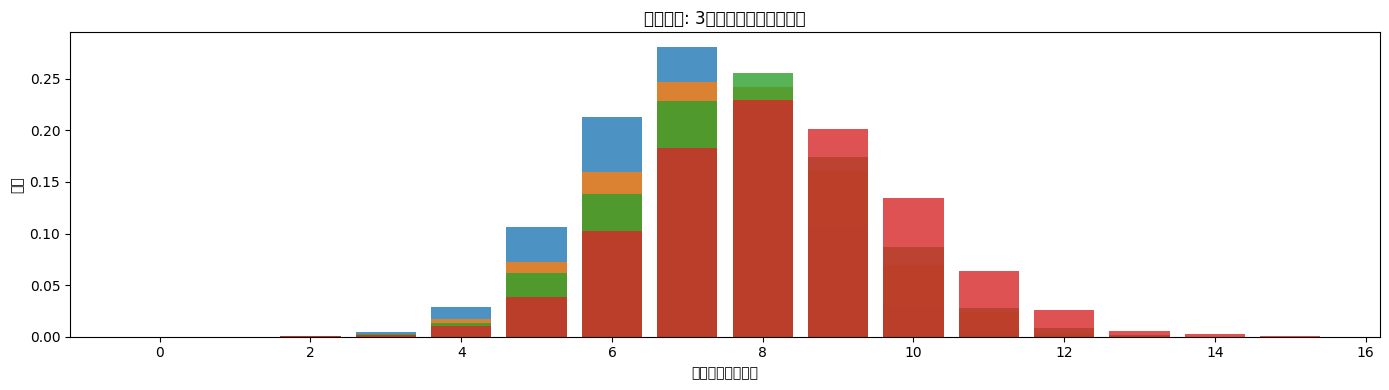

/Users/K/miniforge3/envs/Q/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


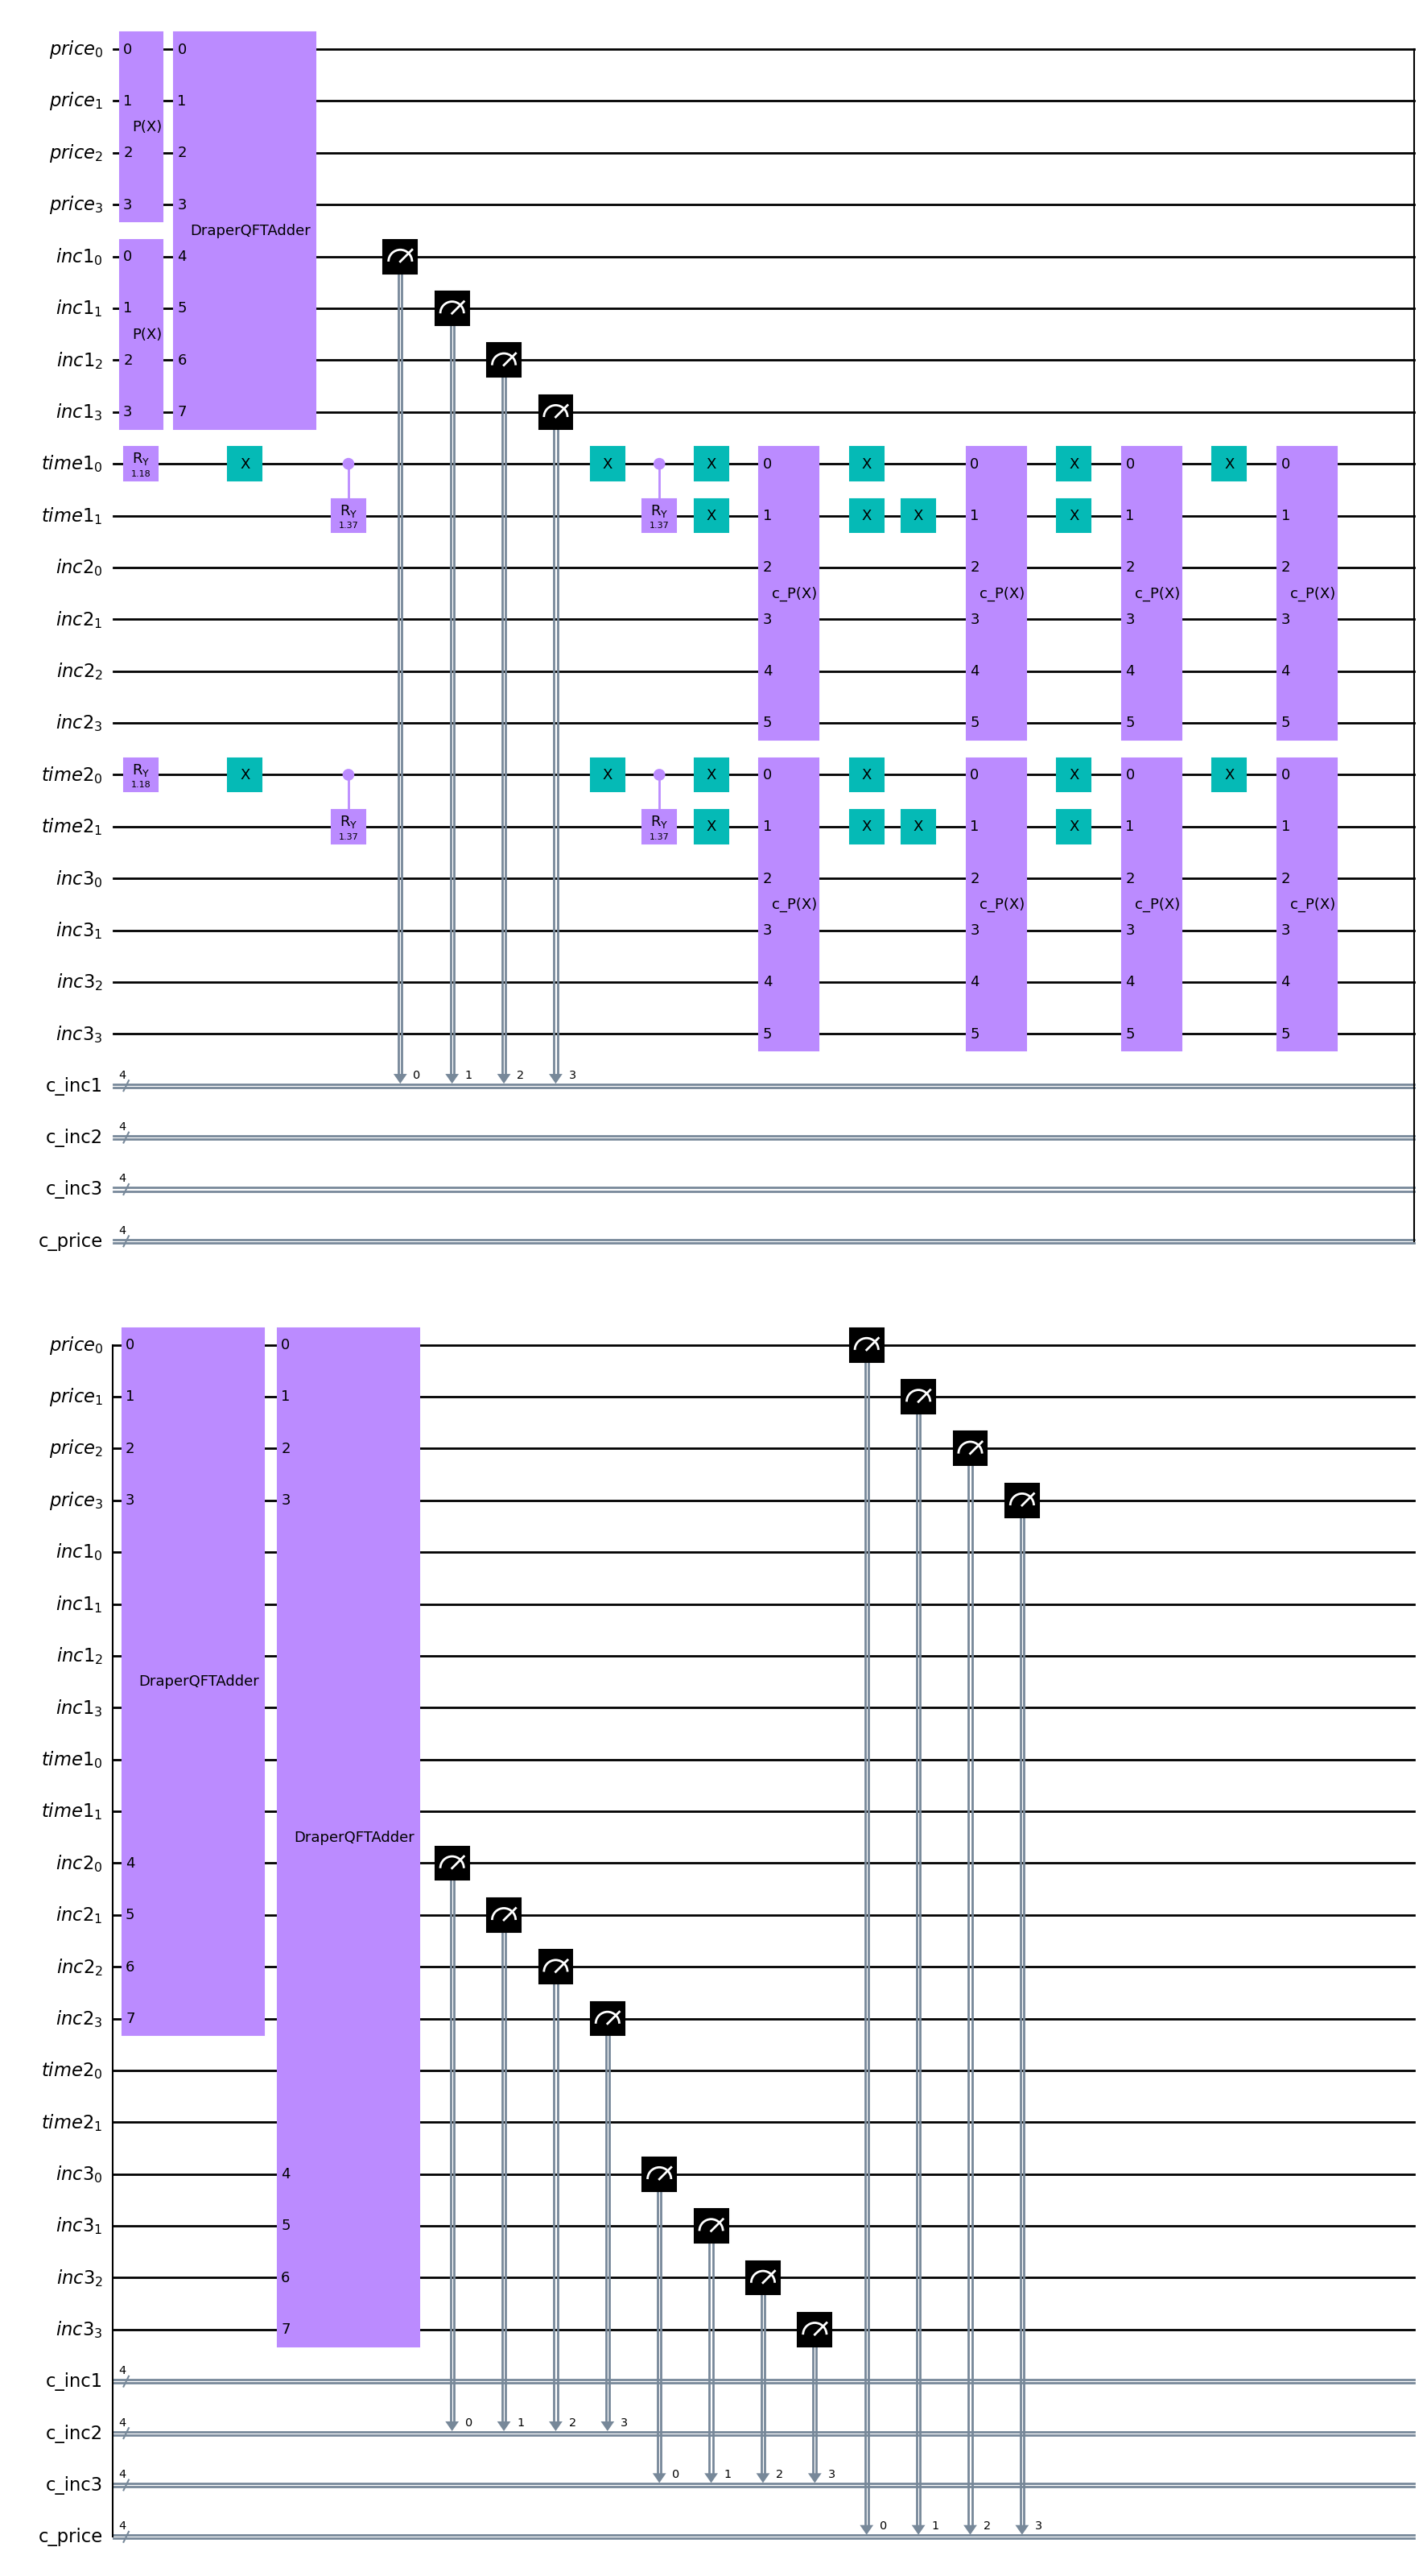

In [31]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.circuit.library import DraperQFTAdder
from qiskit_finance.circuit.library import NormalDistribution

# ─── 1. パラメータ設定 ─────────────────────────────────────────
n = 4                    # 価格・増分を 4ビットで離散化 (16 段階)
dim = 2**n               # 16 段階
p_min = 0.0              # 価格（および増分）の最小値
p_max = 15.0             # 価格（および増分）の最大値

# (1) 初期価格分布 (ステップ0)
mu0    = 7.0             # 初期価格の正規分布平均
sigma0 = 2.0             # 初期価格の正規分布標準偏差

# (2) ステップ1 のインクリメント分布 (固定)
mu_inc1    = 1.0         # ステップ1 インクリメント平均
sigma_inc1 = 1.5         # ステップ1 インクリメント標準偏差

# (3) ステップ2 のインクリメント分布ベースパラメータ (ホールディングタイム対応)
mu_inc2     = 0.5        # 平均
sigma_base2 = 1.0        # ベース標準偏差
# 実際には σ₂,j = sigma_base2 * sqrt(τ_j)

# (4) ステップ3 のインクリメント分布ベースパラメータ (新規ホールディングタイム対応)
mu_inc3     = 0.3        # 平均 (任意に設定)
sigma_base3 = 0.8        # ベース標準偏差
# 実際には σ₃,j = sigma_base3 * sqrt(τ_j)

# (5) ホールディングタイム (ΔT) 分布を指数分布 Exp(1) として 4 段階に離散化 (ステップ2/ステップ3 両用)
m = 2  # 2ビット → 4 段階
tau_vals = np.array([0.2, 0.6, 1.0, 1.4])  # j=0..3 に対応する ΔT の値
raw = np.exp(-tau_vals)                    # Exp(1) の PDF ∝ exp(-t)
pi_tau = raw / raw.sum()                   # 4 段階の確率質量

# ─── 2. レジスタ定義 ────────────────────────────────────────────
# 量子レジスタ（合計：価格4ビット + inc1 4ビット + time1 2ビット + inc2 4ビット + time2 2ビット + inc3 4ビット = 20 qubits）
qr_price = QuantumRegister(n, name="price")    # 0..3: 価格レジスタ
qr_inc1  = QuantumRegister(n, name="inc1")     # 4..7: ステップ1 インクリメント
qr_time1 = QuantumRegister(m, name="time1")    # 8..9: ステップ2 ホールディングタイム
qr_inc2  = QuantumRegister(n, name="inc2")     # 10..13: ステップ2 インクリメント
qr_time2 = QuantumRegister(m, name="time2")    # 14..15: ステップ3 ホールディングタイム
qr_inc3  = QuantumRegister(n, name="inc3")     # 16..19: ステップ3 インクリメント

# 古典レジスタ（各 4 ビットずつ、合計 16 ビット）
cr_inc1  = ClassicalRegister(n, name="c_inc1")  # inc1 測定用
cr_inc2  = ClassicalRegister(n, name="c_inc2")  # inc2 測定用
cr_inc3  = ClassicalRegister(n, name="c_inc3")  # inc3 測定用
cr_price = ClassicalRegister(n, name="c_price") # 最終価格測定用

qc = QuantumCircuit(
    qr_price, qr_inc1, qr_time1, qr_inc2, qr_time2, qr_inc3,
    cr_inc1, cr_inc2, cr_inc3, cr_price
)

# ─── 3. 回路構築 ───────────────────────────────────────────────

# 3.1 (ステップ0) 初期価格分布を qr_price に生成
init_dist = NormalDistribution(
    num_qubits=n,
    mu=mu0,
    sigma=sigma0,
    bounds=(p_min, p_max)
)
qc.append(init_dist, qr_price)

# 3.2 (ステップ1) インクリメント1 を qr_inc1 に生成
inc1_dist = NormalDistribution(
    num_qubits=n,
    mu=mu_inc1,
    sigma=sigma_inc1,
    bounds=(p_min, p_max)
)
qc.append(inc1_dist, qr_inc1)

# 3.3 (ステップ1) DraperQFTAdder で「価格 ← 価格 + インクリメント1」
adder1 = DraperQFTAdder(num_state_qubits=n)
qc.append(adder1, qr_price[:] + qr_inc1[:])

# 3.4 (ステップ2) ホールディングタイム分布を qr_time1 に準備
theta1_2 = 2 * np.arccos(np.sqrt(pi_tau[0] + pi_tau[1]))
qc.ry(theta1_2, qr_time1[0])
phi0_2 = (2 * np.arccos(np.sqrt(pi_tau[0]/(pi_tau[0]+pi_tau[1]))) 
          if (pi_tau[0]+pi_tau[1])>0 else 0.0)
phi1_2 = (2 * np.arccos(np.sqrt(pi_tau[2]/(pi_tau[2]+pi_tau[3]))) 
          if (pi_tau[2]+pi_tau[3])>0 else 0.0)

# qr_time1[0]=|0> のとき qr_time1[1] を φ0_2 回転
qc.x(qr_time1[0])
qc.cry(phi0_2, qr_time1[0], qr_time1[1])
qc.x(qr_time1[0])
# qr_time1[0]=|1> のとき qr_time1[1] を φ1_2 回転
qc.cry(phi1_2, qr_time1[0], qr_time1[1])
# ここまでで qr_time1 = √π₀|00> + √π₁|01> + √π₂|10> + √π₃|11> の状態

# 3.5 (ステップ2) ホールディングタイムに応じたインクリメント2 を qr_inc2 に準備
norm_circs2 = []
for j in range(4):
    sigma2_j = sigma_base2 * np.sqrt(tau_vals[j])  # σ₂,j
    dist2_j = NormalDistribution(
        num_qubits=n,
        mu=mu_inc2,
        sigma=sigma2_j,
        bounds=(p_min, p_max)
    )
    norm_circs2.append(dist2_j)

# 各 j について「qr_time1 = |j> のとき dist2_j を qr_inc2 に適用」
for j in range(4):
    bstr = format(j, f'0{m}b')[::-1]
    for idx in range(m):
        if bstr[idx] == '0':
            qc.x(qr_time1[idx])
    qc.append(norm_circs2[j].control(2), qr_time1[:] + qr_inc2[:])
    for idx in range(m):
        if bstr[idx] == '0':
            qc.x(qr_time1[idx])

# 3.6 (ステップ2) DraperQFTAdder で「価格 ← 価格 + インクリメント2」
adder2 = DraperQFTAdder(num_state_qubits=n)
qc.append(adder2, qr_price[:] + qr_inc2[:])

# 3.7 (ステップ3) 新たにホールディングタイム分布を qr_time2 に準備
theta1_3 = 2 * np.arccos(np.sqrt(pi_tau[0] + pi_tau[1]))
qc.ry(theta1_3, qr_time2[0])
phi0_3 = (2 * np.arccos(np.sqrt(pi_tau[0]/(pi_tau[0]+pi_tau[1]))) 
          if (pi_tau[0]+pi_tau[1])>0 else 0.0)
phi1_3 = (2 * np.arccos(np.sqrt(pi_tau[2]/(pi_tau[2]+pi_tau[3]))) 
          if (pi_tau[2]+pi_tau[3])>0 else 0.0)

qc.x(qr_time2[0])
qc.cry(phi0_3, qr_time2[0], qr_time2[1])
qc.x(qr_time2[0])
qc.cry(phi1_3, qr_time2[0], qr_time2[1])
# これで qr_time2 = √π₀|00> + √π₁|01> + √π₂|10> + √π₃|11>

# 3.8 (ステップ3) ホールディングタイムに応じたインクリメント3 を qr_inc3 に準備
norm_circs3 = []
for j in range(4):
    sigma3_j = sigma_base3 * np.sqrt(tau_vals[j])  # σ₃,j
    dist3_j = NormalDistribution(
        num_qubits=n,
        mu=mu_inc3,
        sigma=sigma3_j,
        bounds=(p_min, p_max)
    )
    norm_circs3.append(dist3_j)

# 各 j について「qr_time2 = |j> のとき dist3_j を qr_inc3 に適用」
for j in range(4):
    bstr = format(j, f'0{m}b')[::-1]
    for idx in range(m):
        if bstr[idx] == '0':
            qc.x(qr_time2[idx])
    qc.append(norm_circs3[j].control(2), qr_time2[:] + qr_inc3[:])
    for idx in range(m):
        if bstr[idx] == '0':
            qc.x(qr_time2[idx])

# 3.9 (ステップ3) DraperQFTAdder で「価格 ← 価格 + インクリメント3」
adder3 = DraperQFTAdder(num_state_qubits=n)
qc.append(adder3, qr_price[:] + qr_inc3[:])

# 3.10 「インクリメント1」「インクリメント2」「インクリメント3」「価格レジスタ」を測定
qc.measure(qr_inc1,  cr_inc1)
qc.measure(qr_inc2,  cr_inc2)
qc.measure(qr_inc3,  cr_inc3)
qc.measure(qr_price, cr_price)

# ─── 4. シミュレーション実行 ──────────────────────────────────
backend = Aer.get_backend('aer_simulator')
shots = 8000
job = execute(qc, backend=backend, shots=shots)
result = job.result()
counts = result.get_counts()

# ─── 5. 測定結果の集計 ───────────────────────────────────────
counts_inc1  = np.zeros(dim, dtype=int)
counts_inc2  = np.zeros(dim, dtype=int)
counts_inc3  = np.zeros(dim, dtype=int)
counts_price = np.zeros(dim, dtype=int)

# Qiskit の counts のキー bitstr は「'inc1 inc2 inc3 price'」のように
# 空白で区切られた四つの 4-bit 部分列になるので、split() してそれぞれ整数化
for bitstr, cnt in counts.items():
    parts = bitstr.split()   # ['xxxx','yyyy','zzzz','wwww']
    inc1_str  = parts[0]     # step1インクリメント
    inc2_str  = parts[1]     # step2インクリメント
    inc3_str  = parts[2]     # step3インクリメント
    price_str = parts[3]     # 最終価格

    k1  = int(inc1_str,  2)
    k2  = int(inc2_str,  2)
    k3  = int(inc3_str,  2)
    kp  = int(price_str, 2)

    counts_inc1[k1]   += cnt
    counts_inc2[k2]   += cnt
    counts_inc3[k3]   += cnt
    counts_price[kp]  += cnt

pmf_inc1  = counts_inc1  / shots
pmf_inc2  = counts_inc2  / shots
pmf_inc3  = counts_inc3  / shots
pmf_price = counts_price / shots

# ─── 6. 結果をプロット ───────────────────────────────────────
k_vals = np.arange(dim)
p_vals = p_min + (k_vals / (dim - 1)) * (p_max - p_min)

plt.figure(figsize=(14, 4))

# (A) ステップ1 インクリメント
plt.bar(p_vals, pmf_inc1, width=(p_vals[1] - p_vals[0]) * 0.8,
        color='C0', alpha=0.8)
plt.bar(p_vals, pmf_inc2, width=(p_vals[1] - p_vals[0]) * 0.8,
        color='C1', alpha=0.8)
plt.bar(p_vals, pmf_inc3, width=(p_vals[1] - p_vals[0]) * 0.8,
        color='C2', alpha=0.8)
plt.bar(p_vals, pmf_price, width=(p_vals[1] - p_vals[0]) * 0.8,
        color='C3', alpha=0.8)
plt.xlabel("最終価格の離散値")
plt.ylabel("確率")
plt.title("量子測定: 3ステップ後の価格分布")

plt.tight_layout()
plt.show()

# （オプション）構築した量子回路を描画して確認する場合
qc.draw(output="mpl")



/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/1262848528.py:262: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/1262848528.py:262: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/1262848528.py:262: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/1262848528.py:262: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/1262848528.py:262: UserWarning: Glyph 12513 (\N{KATAKANA LETTER ME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykerne

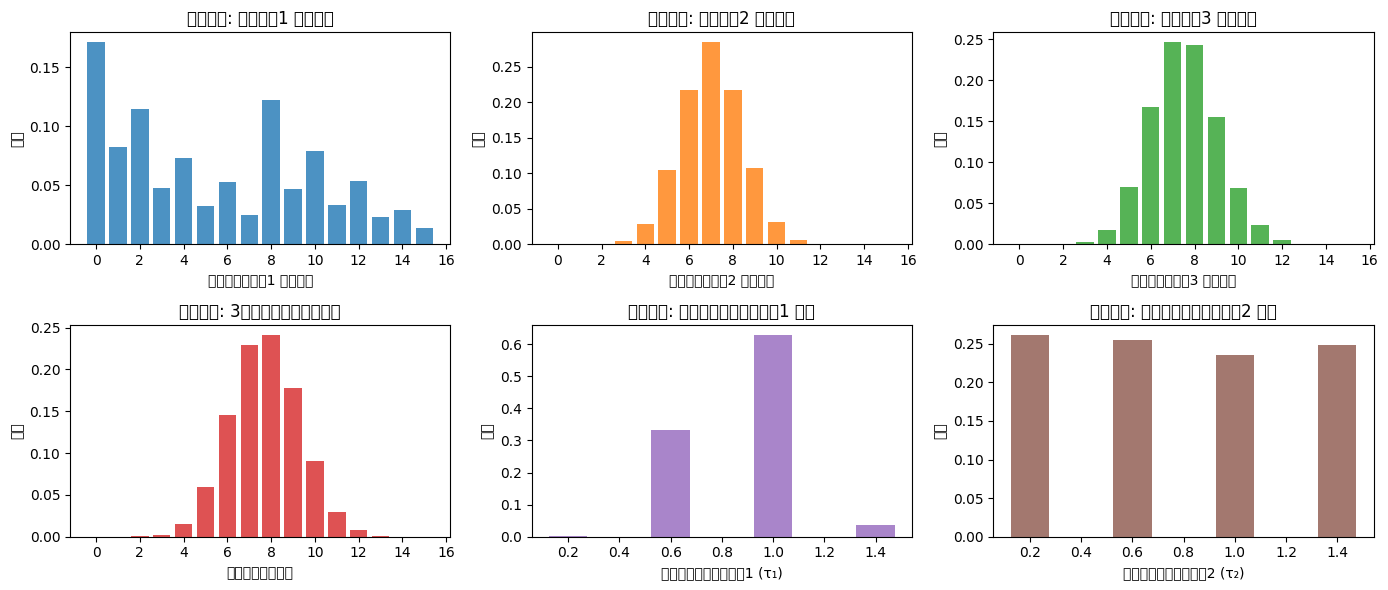

/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/1262848528.py:272: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/1262848528.py:272: UserWarning: Glyph 35336 (\N{CJK UNIFIED IDEOGRAPH-8A08}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/1262848528.py:272: UserWarning: Glyph 12507 (\N{KATAKANA LETTER HO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/1262848528.py:272: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_91581/1262848528.py:272: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/3n/5qp

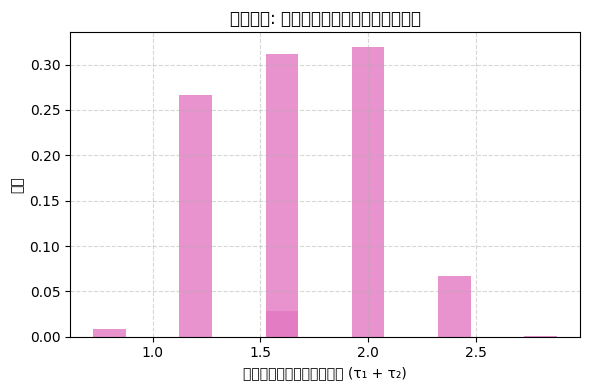

/Users/K/miniforge3/envs/Q/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


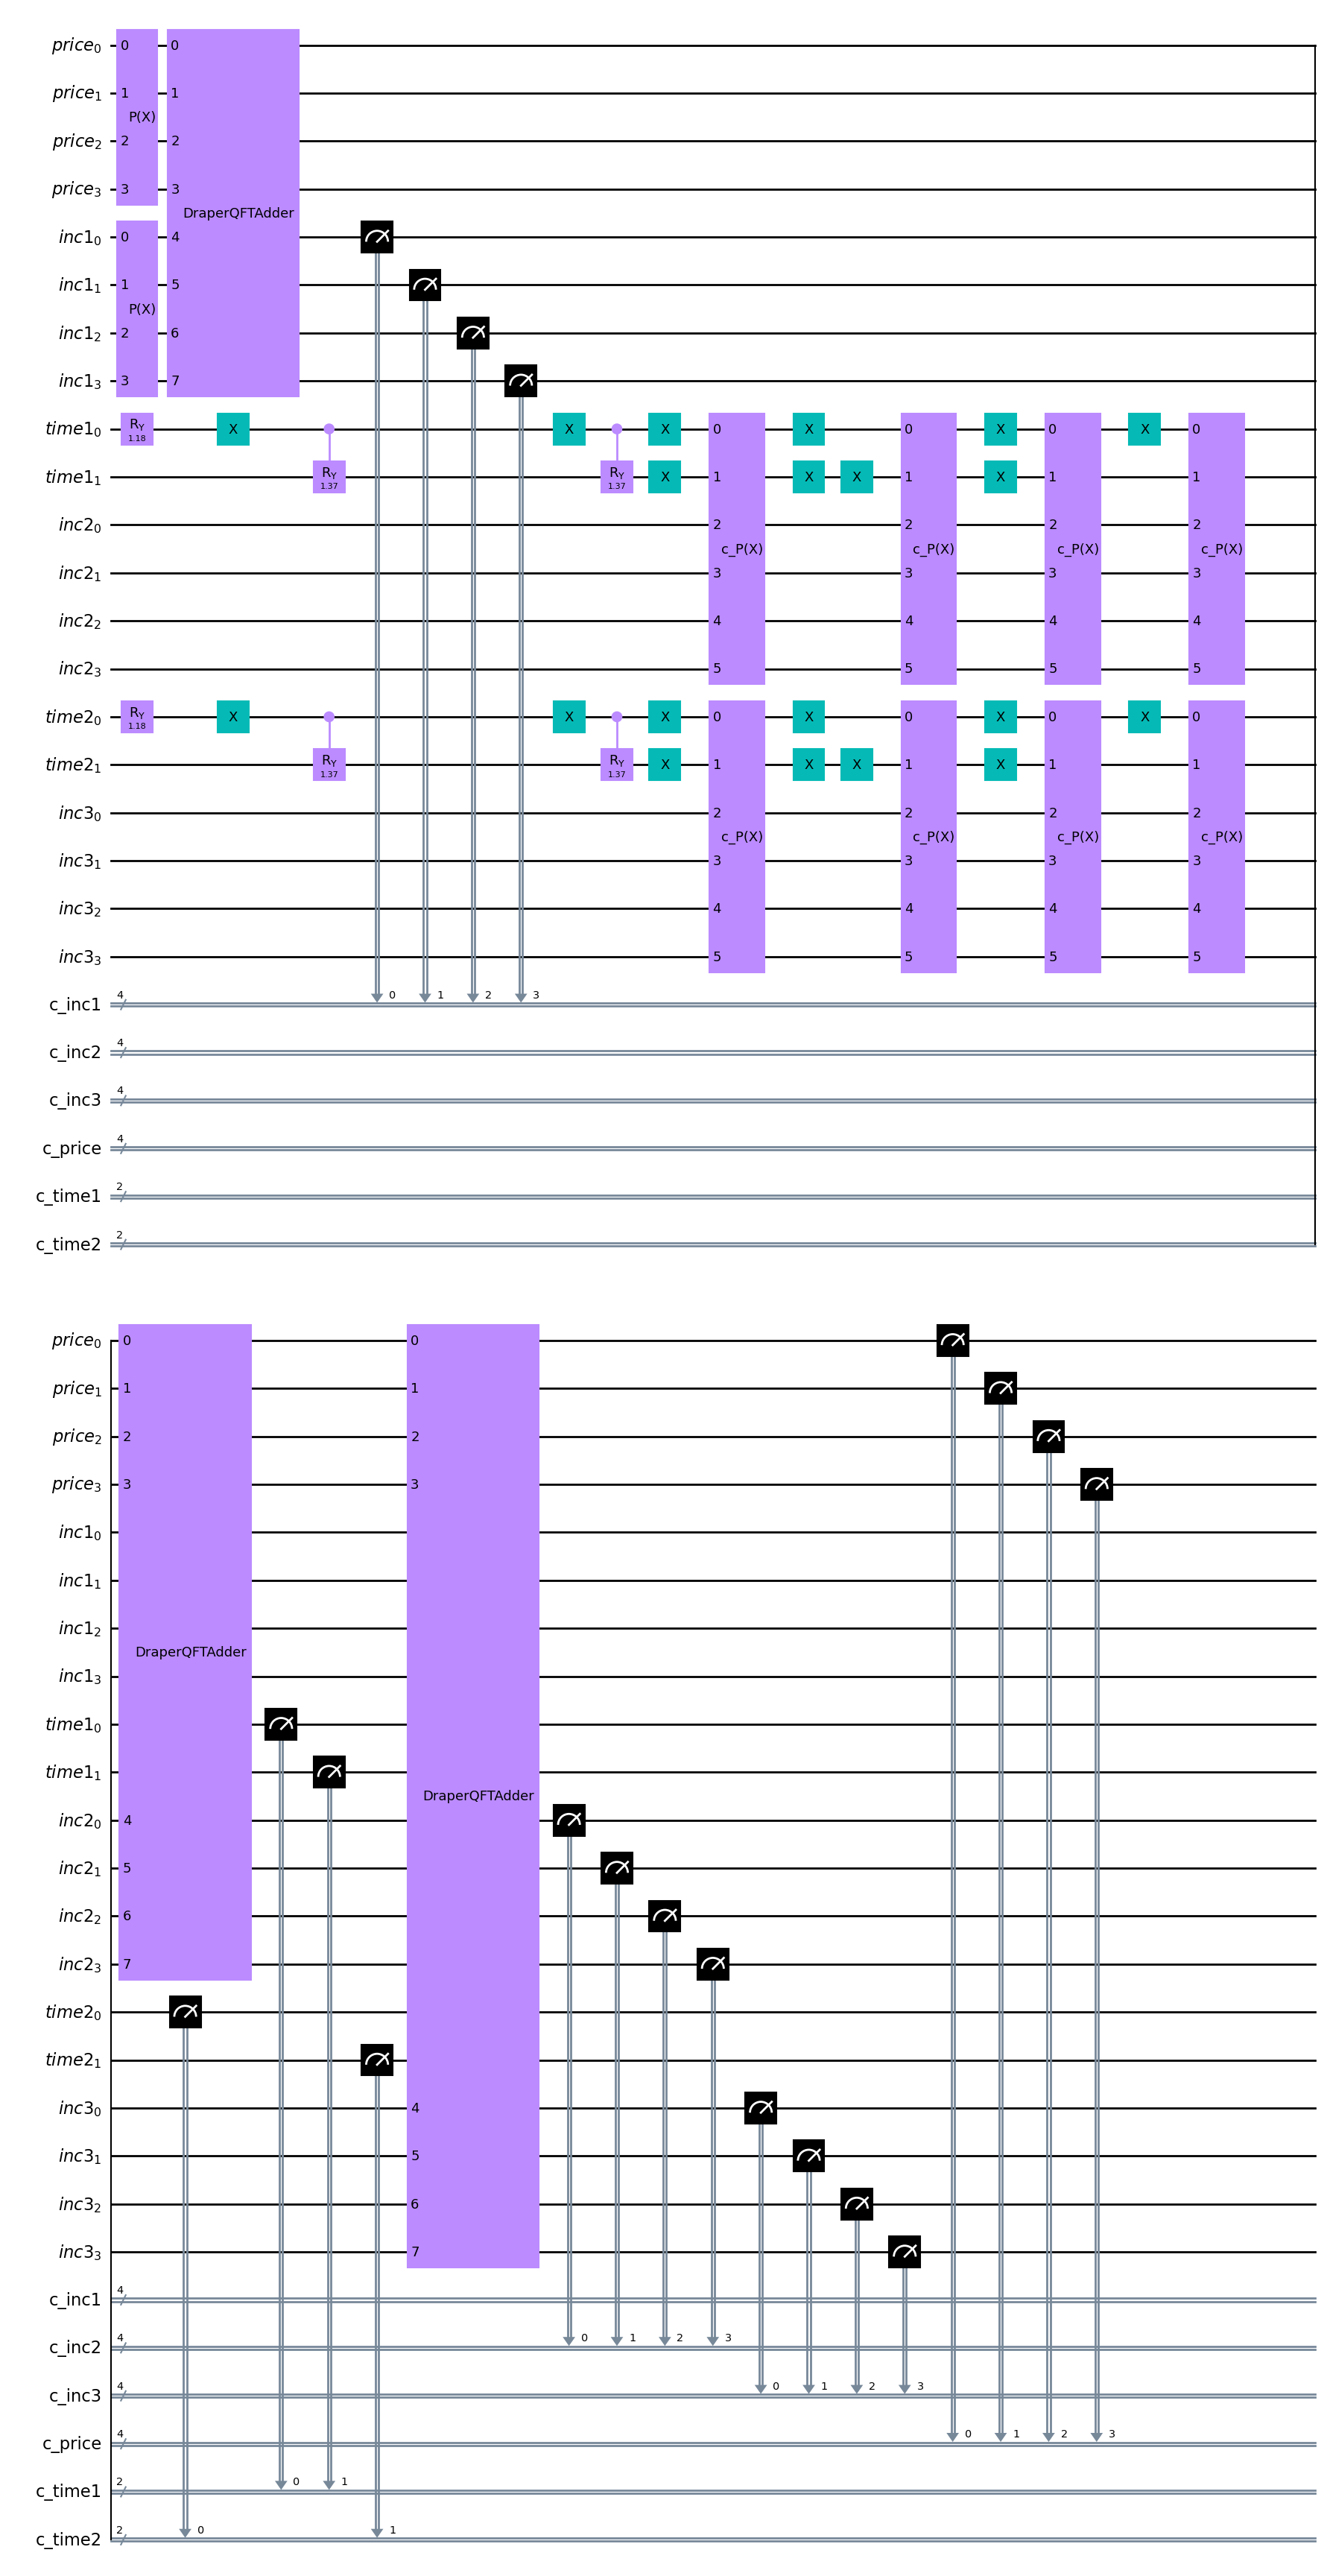

In [34]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.circuit.library import DraperQFTAdder
from qiskit_finance.circuit.library import NormalDistribution

# ─── 1. パラメータ設定 ─────────────────────────────────────────
n = 4                    # 価格・増分を 4ビットで離散化 (16 段階)
dim = 2**n               # 16 段階
p_min = 0.0              # 価格（および増分）の最小値
p_max = 15.0             # 価格（および増分）の最大値

# (1) 初期価格分布 (ステップ0)
mu0    = 7.0             # 初期価格の平均
sigma0 = 2.0             # 初期価格の標準偏差

# (2) ステップ1 のインクリメント分布 (固定)
mu_inc1    = 1.0         # ステップ1 インクリメント平均
sigma_inc1 = 1.5         # ステップ1 インクリメント標準偏差

# (3) ステップ2 のインクリメント分布ベースパラメータ (ホールディングタイム対応)
mu_inc2     = 0.5        # 平均
sigma_base2 = 1.0        # ベース標準偏差

# (4) ステップ3 のインクリメント分布ベースパラメータ (ホールディングタイム対応)
mu_inc3     = 0.3        # 平均
sigma_base3 = 0.8        # ベース標準偏差

# (5) ホールディングタイム (ΔT) 分布を指数分布 Exp(1) として 4 段階に離散化
m = 2  # 2 ビット → 4 段階
tau_vals = np.array([0.2, 0.6, 1.0, 1.4])  # j=0..3 に対応する ΔT の値
raw = np.exp(-tau_vals)                    # Exp(1) の PDF ∝ exp(-t)
pi_tau = raw / raw.sum()                   # 4 段階の確率質量

# ─── 2. 量子レジスタと古典レジスタの準備 ─────────────────────────
qr_price = QuantumRegister(n, name="price")    # 0..3: 価格レジスタ
qr_inc1  = QuantumRegister(n, name="inc1")     # 4..7: ステップ1 インクリメント
qr_time1 = QuantumRegister(m, name="time1")    # 8..9: ステップ2 ホールディングタイム
qr_inc2  = QuantumRegister(n, name="inc2")     # 10..13: ステップ2 インクリメント
qr_time2 = QuantumRegister(m, name="time2")    # 14..15: ステップ3 ホールディングタイム
qr_inc3  = QuantumRegister(n, name="inc3")     # 16..19: ステップ3 インクリメント

# 古典レジスタ
cr_inc1  = ClassicalRegister(n, name="c_inc1")  # inc1 測定用 (4ビット)
cr_inc2  = ClassicalRegister(n, name="c_inc2")  # inc2 測定用 (4ビット)
cr_inc3  = ClassicalRegister(n, name="c_inc3")  # inc3 測定用 (4ビット)
cr_price = ClassicalRegister(n, name="c_price") # 最終価格測定用 (4ビット)
cr_time1 = ClassicalRegister(m, name="c_time1") # time1 測定用 (2ビット)
cr_time2 = ClassicalRegister(m, name="c_time2") # time2 測定用 (2ビット)

qc = QuantumCircuit(
    qr_price, qr_inc1, qr_time1, qr_inc2, qr_time2, qr_inc3,
    cr_inc1, cr_inc2, cr_inc3, cr_price, cr_time1, cr_time2
)

# ─── 3. 回路構築 ───────────────────────────────────────────────
# 3.1 初期価格分布を qr_price に生成
init_dist = NormalDistribution(
    num_qubits=n,
    mu=mu0,
    sigma=sigma0,
    bounds=(p_min, p_max)
)
qc.append(init_dist, qr_price)

# 3.2 ステップ1 のインクリメントを qr_inc1 に生成
inc1_dist = NormalDistribution(
    num_qubits=n,
    mu=mu_inc1,
    sigma=sigma_inc1,
    bounds=(p_min, p_max)
)
qc.append(inc1_dist, qr_inc1)

# 3.3 DraperQFTAdder で「価格 ← 価格 + インクリメント1」
adder1 = DraperQFTAdder(num_state_qubits=n)
qc.append(adder1, qr_price[:] + qr_inc1[:])

# 3.4 ステップ2 ホールディングタイムを qr_time1 に準備
theta1_2 = 2 * np.arccos(np.sqrt(pi_tau[0] + pi_tau[1]))
qc.ry(theta1_2, qr_time1[0])
phi0_2 = 2 * np.arccos(np.sqrt(pi_tau[0]/(pi_tau[0]+pi_tau[1]))) if (pi_tau[0]+pi_tau[1])>0 else 0.0
phi1_2 = 2 * np.arccos(np.sqrt(pi_tau[2]/(pi_tau[2]+pi_tau[3]))) if (pi_tau[2]+pi_tau[3])>0 else 0.0
qc.x(qr_time1[0]); qc.cry(phi0_2, qr_time1[0], qr_time1[1]); qc.x(qr_time1[0])
qc.cry(phi1_2, qr_time1[0], qr_time1[1])

# 3.5 ステップ2 インクリメントを qr_inc2 に準備 (ホールディングタイム制御)
norm_circs2 = []
for j in range(4):
    sigma2_j = sigma_base2 * np.sqrt(tau_vals[j])
    dist2_j = NormalDistribution(
        num_qubits=n,
        mu=mu_inc2,
        sigma=sigma2_j,
        bounds=(p_min, p_max)
    )
    norm_circs2.append(dist2_j)

for j in range(4):
    bstr = format(j, f'0{m}b')[::-1]
    for idx in range(m):
        if bstr[idx] == '0':
            qc.x(qr_time1[idx])
    qc.append(norm_circs2[j].control(2), qr_time1[:] + qr_inc2[:])
    for idx in range(m):
        if bstr[idx] == '0':
            qc.x(qr_time1[idx])

# 3.6 ステップ2 加算
adder2 = DraperQFTAdder(num_state_qubits=n)
qc.append(adder2, qr_price[:] + qr_inc2[:])

# 3.7 ステップ3 ホールディングタイムを qr_time2 に準備
theta1_3 = 2 * np.arccos(np.sqrt(pi_tau[0] + pi_tau[1]))
qc.ry(theta1_3, qr_time2[0])
phi0_3 = 2 * np.arccos(np.sqrt(pi_tau[0]/(pi_tau[0]+pi_tau[1]))) if (pi_tau[0]+pi_tau[1])>0 else 0.0
phi1_3 = 2 * np.arccos(np.sqrt(pi_tau[2]/(pi_tau[2]+pi_tau[3]))) if (pi_tau[2]+pi_tau[3])>0 else 0.0
qc.x(qr_time2[0]); qc.cry(phi0_3, qr_time2[0], qr_time2[1]); qc.x(qr_time2[0])
qc.cry(phi1_3, qr_time2[0], qr_time2[1])

# 3.8 ステップ3 インクリメントを qr_inc3 に準備 (ホールディングタイム制御)
norm_circs3 = []
for j in range(4):
    sigma3_j = sigma_base3 * np.sqrt(tau_vals[j])
    dist3_j = NormalDistribution(
        num_qubits=n,
        mu=mu_inc3,
        sigma=sigma3_j,
        bounds=(p_min, p_max)
    )
    norm_circs3.append(dist3_j)

for j in range(4):
    bstr = format(j, f'0{m}b')[::-1]
    for idx in range(m):
        if bstr[idx] == '0':
            qc.x(qr_time2[idx])
    qc.append(norm_circs3[j].control(2), qr_time2[:] + qr_inc3[:])
    for idx in range(m):
        if bstr[idx] == '0':
            qc.x(qr_time2[idx])

# 3.9 ステップ3 加算
adder3 = DraperQFTAdder(num_state_qubits=n)
qc.append(adder3, qr_price[:] + qr_inc3[:])

# 3.10 測定：inc1, inc2, inc3, price, time1, time2 をすべて測定
qc.measure(qr_inc1,  cr_inc1)
qc.measure(qr_inc2,  cr_inc2)
qc.measure(qr_inc3,  cr_inc3)
qc.measure(qr_price, cr_price)
qc.measure(qr_time1, cr_time1)
qc.measure(qr_time2, cr_time2)

# ─── 4. シミュレーション実行 ──────────────────────────────────
backend = Aer.get_backend('aer_simulator')
shots = 8000
job = execute(qc, backend=backend, shots=shots)
result = job.result()
counts = result.get_counts()

# ─── 5. 測定結果の集計 ───────────────────────────────────────
counts_inc1   = np.zeros(dim, dtype=int)
counts_inc2   = np.zeros(dim, dtype=int)
counts_inc3   = np.zeros(dim, dtype=int)
counts_price  = np.zeros(dim, dtype=int)
counts_time1  = np.zeros(4,   dtype=int)
counts_time2  = np.zeros(4,   dtype=int)
counts_time_sum = {}  # 合計 holding time (τ₁+τ₂) をキーにカウント

for bitstr, cnt in counts.items():
    # bitstr は空白を除くと 20 ビット連続の文字列になるので、まず空白を除去する
    bs = bitstr.replace(" ", "")
    # bs を長さ固定 (20) で扱い、各レジスタに対応するビットを切り出す
    #  順序は measure() を呼んだ順に対応すると仮定：
    #   - inc1 (4ビット) → bs[0:4]
    #   - inc2 (4ビット) → bs[4:8]
    #   - inc3 (4ビット) → bs[8:12]
    #   - price(4ビット)→ bs[12:16]
    #   - time1(2ビット)→ bs[16:18]
    #   - time2(2ビット)→ bs[18:20]
    inc1_bits  = bs[0:4]
    inc2_bits  = bs[4:8]
    inc3_bits  = bs[8:12]
    price_bits = bs[12:16]
    time1_bits = bs[16:18]
    time2_bits = bs[18:20]

    k1  = int(inc1_bits,  2)
    k2  = int(inc2_bits,  2)
    k3  = int(inc3_bits,  2)
    kp  = int(price_bits, 2)
    t1  = int(time1_bits, 2)  # 0..3
    t2  = int(time2_bits, 2)  # 0..3

    counts_inc1[k1]   += cnt
    counts_inc2[k2]   += cnt
    counts_inc3[k3]   += cnt
    counts_price[kp]  += cnt
    counts_time1[t1]  += cnt
    counts_time2[t2]  += cnt

    # 合計 holding time = τ_vals[t1] + τ_vals[t2]
    tsum = tau_vals[t1] + tau_vals[t2]
    counts_time_sum[tsum] = counts_time_sum.get(tsum, 0) + cnt

pmf_inc1    = counts_inc1   / shots
pmf_inc2    = counts_inc2   / shots
pmf_inc3    = counts_inc3   / shots
pmf_price   = counts_price  / shots
pmf_time1   = counts_time1  / shots
pmf_time2   = counts_time2  / shots

# 合計 holding time の PMF
unique_ts = sorted(counts_time_sum.keys())
pmf_time_sum = np.array([counts_time_sum[t] / shots for t in unique_ts])

# ─── 6. 結果をプロット ───────────────────────────────────────
k_vals = np.arange(dim)
p_vals = p_min + (k_vals / (dim - 1)) * (p_max - p_min)

plt.figure(figsize=(14, 6))

# (A) ステップ1 インクリメント
plt.subplot(2, 3, 1)
plt.bar(p_vals, pmf_inc1, width=(p_vals[1] - p_vals[0]) * 0.8, color='C0', alpha=0.8)
plt.xlabel("インクリメント1 の離散値");    plt.ylabel("確率")
plt.title("量子測定: ステップ1 増分分布")

# (B) ステップ2 インクリメント
plt.subplot(2, 3, 2)
plt.bar(p_vals, pmf_inc2, width=(p_vals[1] - p_vals[0]) * 0.8, color='C1', alpha=0.8)
plt.xlabel("インクリメント2 の離散値");    plt.ylabel("確率")
plt.title("量子測定: ステップ2 増分分布")

# (C) ステップ3 インクリメント
plt.subplot(2, 3, 3)
plt.bar(p_vals, pmf_inc3, width=(p_vals[1] - p_vals[0]) * 0.8, color='C2', alpha=0.8)
plt.xlabel("インクリメント3 の離散値");    plt.ylabel("確率")
plt.title("量子測定: ステップ3 増分分布")

# (D) 最終価格
plt.subplot(2, 3, 4)
plt.bar(p_vals, pmf_price, width=(p_vals[1] - p_vals[0]) * 0.8, color='C3', alpha=0.8)
plt.xlabel("最終価格の離散値");           plt.ylabel("確率")
plt.title("量子測定: 3ステップ後の価格分布")

# (E) ステップ2 ホールディングタイム分布
plt.subplot(2, 3, 5)
plt.bar(tau_vals, pmf_time1, width=0.15, color='C4', alpha=0.8)
plt.xlabel("ホールディングタイム1 (τ₁)"); plt.ylabel("確率")
plt.title("量子測定: ホールディングタイム1 分布")

# (F) ステップ3 ホールディングタイム分布
plt.subplot(2, 3, 6)
plt.bar(tau_vals, pmf_time2, width=0.15, color='C5', alpha=0.8)
plt.xlabel("ホールディングタイム2 (τ₂)"); plt.ylabel("確率")
plt.title("量子測定: ホールディングタイム2 分布")

plt.tight_layout()
plt.show()

# 合計ホールディングタイムの分布を別プロット
plt.figure(figsize=(6, 4))
plt.bar(unique_ts, pmf_time_sum, width=0.15, color='C6', alpha=0.8)
plt.xlabel("合計ホールディングタイム (τ₁ + τ₂)")
plt.ylabel("確率")
plt.title("量子測定: 合計ホールディングタイム分布")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

qc.draw(output="mpl")
